In [4]:
# Iizumi の輸出入 CSV を読み込み、国→国の輸出入行列（pivot）を作るノート

#このノートでは、'Iizumi/Trade_DetailedTradeMatrix_E_All_Data_NOFLAG.csv' を読み込み、各国（報告国）から各国（相手国）への輸出/輸入を集計した行列を作ります。

#実行はステップごとに分かれています。まずはセルを上から順に実行してください。

In [1]:
import sys, os
print("executable:", sys.executable)
print("version:", sys.version.split()[0])


executable: /home/tsuda/anaconda3/envs/nb312/bin/python
version: 3.12.11


In [2]:
# --- セクション 1: 必要なライブラリと CSV パスの定義
import pandas as pd
from pathlib import Path
from typing import Dict, Optional

# CSV のパス（必要に応じて変更してください）
DATA_CSV = Path("Trade_DetailedTradeMatrix_E_All_Data_NOFLAG.csv")

# 小さなユーティリティ: 表示用の Pandas 設定
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 160)


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from pathlib import Path

# ===== 設定 =====


READ_FULL = True   # True: 全行読む / False: 先頭N行だけ読む
N = 10000           # READ_FULL=False のときだけ使われる

# ===== 1) 読み込み =====
print("=== Loading CSV ===")
if READ_FULL:
    df = pd.read_csv(DATA_CSV, low_memory=False)
else:
    df = pd.read_csv(DATA_CSV, nrows=N, low_memory=False)

print("loaded:", DATA_CSV)
print("shape:", df.shape)
print("columns:", len(df.columns))

# ===== 2) 列名一覧 =====
print("\n=== Columns list ===")
for i, c in enumerate(df.columns):
    print(f"{i:02d}: {c}")

# ===== 3) dtypeと欠損率 =====
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_missing": df.isna().sum(),
    "missing_rate": (df.isna().mean() * 100).round(2),
    "n_unique": df.nunique(dropna=True),
}).sort_values(["missing_rate", "n_unique"], ascending=[False, False])

print("\n=== Column stats (sorted by missing_rate, n_unique) ===")
display(info)

# ===== 4) 「カテゴリっぽい列」候補（ユニーク数が少ない） =====
cat_candidates = info[info["n_unique"].between(2, 50)].sort_values("n_unique")
print("\n=== Categorical-like columns (2~50 unique) ===")
display(cat_candidates)

# ===== 5) 代表的な値を覗く（上位10件） =====
def show_top_values(col, k=10):
    vc = df[col].value_counts(dropna=False).head(k)
    out = vc.rename_axis(col).reset_index(name="count")
    out["rate_%"] = (out["count"] / len(df) * 100).round(2)
    return out

print("\n=== Preview top values for categorical-like columns ===")
for col in cat_candidates.index[:10]:  # 多すぎると大変なので上位10列だけ
    print(f"\n--- {col} ---")
    display(show_top_values(col, k=10))

# ===== 6) 数値列の概要 =====
num_cols = df.select_dtypes(include="number").columns.tolist()
print("\n=== Numeric columns ===")
print(num_cols)

if num_cols:
    display(df[num_cols].describe().T)

# ===== 7) サンプル行 =====
print("\n=== Sample rows ===")
display(df.head(5))
display(df.tail(5))


## すぐにとってこれるように（あと、いつの年代を基準にするか）

- ファイル内の列名を表示して、`detect_trade_columns` の推測が正しいか必ず確認してください。
- 年やフロー名はデータセットによって表記揺れがあります（例: 'Export' / 'Exports' / 'EXPORT'）。必要なら `example_flow` をデータに合わせて変更してください。
- 大きなデータの場合、pivot のメモリ使用量に注意してください。必要ならサンプリングや年ごとの分割処理を行ってください。


# 毎回csv読み込むのはめんどくさいから、高速形式？で保存

In [6]:
#df.to_pickle("trade_full.pkl")
#print("saved pickle:", df.shape)
#読み込むときは
import pandas as pd
df = pd.read_pickle("trade_full.pkl")



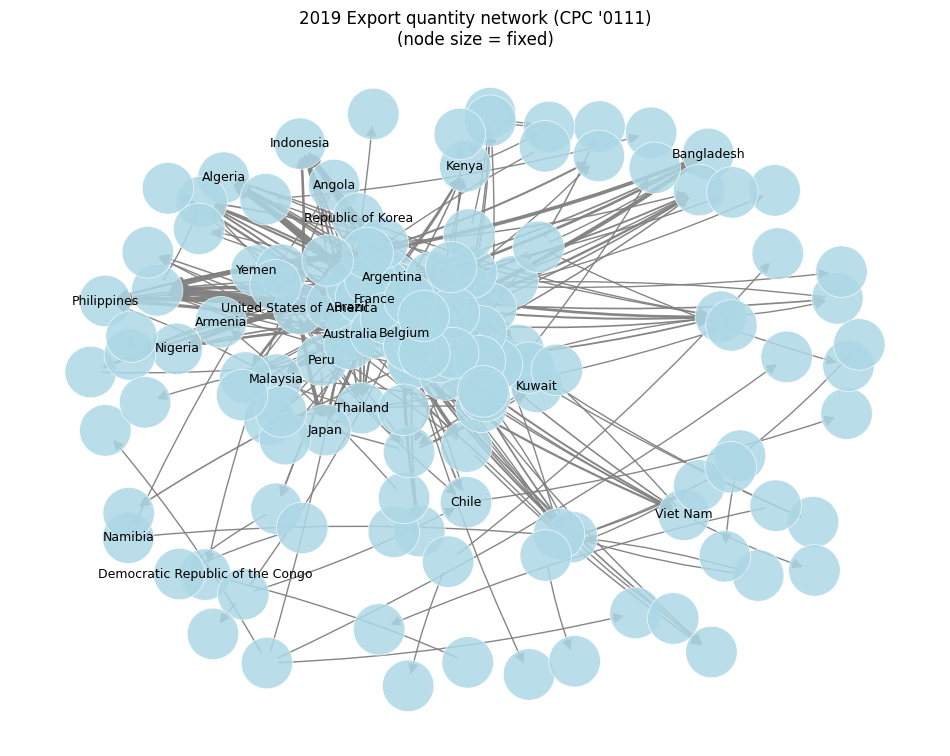

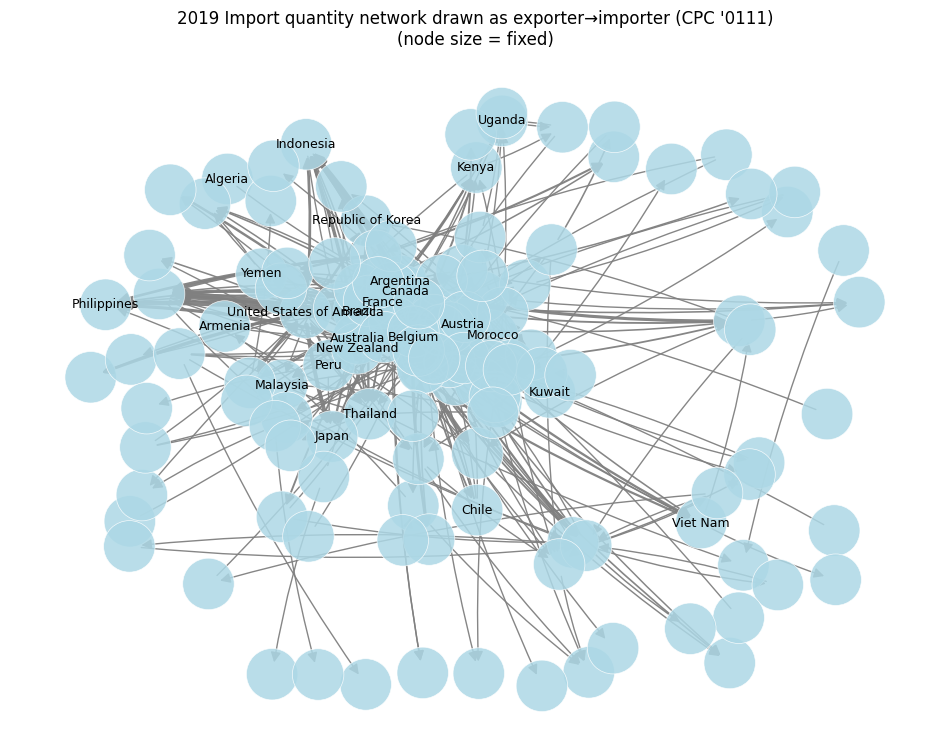

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# =========================================
# Settings (your DF column names are fixed)
# =========================================
REPORTER = "Reporter Countries"
PARTNER  = "Partner Countries"
ITEMCPC  = "Item Code (CPC)"
ELEMENT  = "Element"

# =========================================
# Utilities
# =========================================
def _scale_node_sizes(value_dict, nodes, out_range=(250, 2500), log_scale=True):
    vals = np.array([float(value_dict.get(n, 0.0)) for n in nodes], dtype=float)
    if log_scale:
        vals = np.log1p(vals)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return np.full(len(nodes), np.mean(out_range), dtype=float)
    a, b = out_range
    return a + (vals - vmin) * (b - a) / (vmax - vmin)

def _filter_item_year(df, year=2019, item_code_cpc="'0111"):
    """Pre-filter for speed."""
    ycol = f"Y{year}"
    cols = [REPORTER, PARTNER, ITEMCPC, ELEMENT, ycol]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}")

    d0 = df.loc[df[ITEMCPC].astype(str).str.contains(str(item_code_cpc), na=False), cols].copy()
    d0[ycol] = pd.to_numeric(d0[ycol], errors="coerce").fillna(0.0)
    return d0

def _build_edges_export_quantity(df_item_year, year=2019,
                                dest_share_threshold=0.01, top_n_dest=10):
    """Export quantity: reporter(exporter) -> partner(importer)."""
    ycol = f"Y{year}"
    df2 = df_item_year
    df2 = df2[df2[ELEMENT].astype(str).str.strip().str.lower().eq("export quantity")]

    grp = (df2.groupby([REPORTER, PARTNER], as_index=False)[ycol].sum()
             .rename(columns={REPORTER:"exporter", PARTNER:"importer", ycol:"value"}))

    tot = grp.groupby("exporter", as_index=False)["value"].sum().rename(columns={"value":"exporter_total"})
    grp = grp.merge(tot, on="exporter", how="left")
    grp["dest_share"] = grp["value"] / grp["exporter_total"].replace(0, np.nan)
    grp = grp.dropna(subset=["dest_share"])

    if dest_share_threshold is not None:
        grp = grp[grp["dest_share"] >= dest_share_threshold]
    if top_n_dest is not None:
        grp = (grp.sort_values(["exporter","value"], ascending=[True, False])
                 .groupby("exporter", group_keys=False)
                 .head(top_n_dest))

    return grp.reset_index(drop=True)

def _build_edges_import_quantity_drawn_as_exporter_to_importer(df_item_year, year=2019,
                                                               dest_share_threshold=0.01, top_n_dest=10):
    """
    Import quantity: reporter(importer), partner(exporter) in FAO.
    Draw as partner(exporter) -> reporter(importer).
    """
    ycol = f"Y{year}"
    df2 = df_item_year
    df2 = df2[df2[ELEMENT].astype(str).str.strip().str.lower().eq("import quantity")]

    grp = (df2.groupby([PARTNER, REPORTER], as_index=False)[ycol].sum()
             .rename(columns={PARTNER:"exporter", REPORTER:"importer", ycol:"value"}))

    tot = grp.groupby("exporter", as_index=False)["value"].sum().rename(columns={"value":"exporter_total"})
    grp = grp.merge(tot, on="exporter", how="left")
    grp["dest_share"] = grp["value"] / grp["exporter_total"].replace(0, np.nan)
    grp = grp.dropna(subset=["dest_share"])

    if dest_share_threshold is not None:
        grp = grp[grp["dest_share"] >= dest_share_threshold]
    if top_n_dest is not None:
        grp = (grp.sort_values(["exporter","value"], ascending=[True, False])
                 .groupby("exporter", group_keys=False)
                 .head(top_n_dest))

    return grp.reset_index(drop=True)

def _edges_to_digraph(edges_df):
    G = nx.DiGraph()
    for _, r in edges_df.iterrows():
        u = str(r["exporter"]); v = str(r["importer"]); w = float(r["value"])
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

def _compute_union_pos(edges_a, edges_b, seed=1, k=0.6, iterations=60):
    """Compute layout once on union graph, reuse for both plots."""
    union = pd.concat([edges_a[["exporter","importer","value"]],
                       edges_b[["exporter","importer","value"]]], ignore_index=True)
    Gun = _edges_to_digraph(union)
    pos = nx.spring_layout(Gun, seed=seed, k=k, iterations=iterations)
    return pos

def _node_totals_from_edges(edges_df):
    out_tot = edges_df.groupby("exporter")["value"].sum().to_dict()
    in_tot  = edges_df.groupby("importer")["value"].sum().to_dict()
    return out_tot, in_tot

def plot_trade_network(
    edges_plot,
    title="",
    pos=None,
    node_size_mode="export",          # "export" or "import" or "fixed"
    node_size_range=(250, 2500),
    log_scale=True,
    label_top_n=25,                   # label only top N nodes by node-size metric
    figsize=(12, 9),
    arrowstyle="-|>",
    arrowsize=15,
    connection_rad=0.05,
    edge_alpha=0.95,
    node_alpha=0.85,
):
    if edges_plot is None or edges_plot.empty:
        print("No edges to plot (empty after filters).")
        return

    # Graph
    G = _edges_to_digraph(edges_plot)
    nodes = list(G.nodes())

    # Node size metric from THIS edges_plot (you can swap to edges_all if you want)
    out_tot, in_tot = _node_totals_from_edges(edges_plot)

    if node_size_mode.lower() == "fixed":
        node_sizes = np.full(len(nodes), np.mean(node_size_range), dtype=float)
        size_dict = {n: 1.0 for n in nodes}
        subtitle = "node size = fixed"
    elif node_size_mode.lower() == "import":
        size_dict = in_tot
        node_sizes = _scale_node_sizes(size_dict, nodes, out_range=node_size_range, log_scale=log_scale)
        subtitle = "node size = total import (incoming)"
    else:
        size_dict = out_tot
        node_sizes = _scale_node_sizes(size_dict, nodes, out_range=node_size_range, log_scale=log_scale)
        subtitle = "node size = total export (outgoing)"

    # Layout (REUSE if provided)
    if pos is None:
        pos = nx.spring_layout(G, seed=1, k=0.6, iterations=30)

    # Edge widths
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    maxw = max(weights) if weights else 1.0
    widths = [1 + 5 * (w / maxw) for w in weights]

    plt.figure(figsize=figsize)

    # Nodes (behind)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color="lightblue",
        alpha=node_alpha,
        linewidths=0.5,
        edgecolors="white",
    )

    # Labels: top N only (by size_dict)
    if label_top_n is not None and label_top_n > 0:
        top_nodes = set(pd.Series(size_dict).sort_values(ascending=False).head(label_top_n).index.astype(str))
        labels = {n: n for n in nodes if n in top_nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    # Edges (on top)
    nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color="gray",
        alpha=edge_alpha,
        arrows=True,
        arrowstyle=arrowstyle,
        arrowsize=arrowsize,
        connectionstyle=f"arc3,rad={connection_rad}",
    )

    if title:
        plt.title(f"{title}\n({subtitle})")
    else:
        plt.title(subtitle)

    plt.axis("off")
    plt.show()

def _intersect_edges(edges_a, edges_b):
    """Keep only edges that exist in both (exporter, importer)."""
    key = ["exporter","importer"]
    a = edges_a.copy()
    b = edges_b.copy()
    a["__k"] = a["exporter"].astype(str) + "||" + a["importer"].astype(str)
    b["__k"] = b["exporter"].astype(str) + "||" + b["importer"].astype(str)
    common = set(a["__k"]).intersection(set(b["__k"]))
    a2 = a[a["__k"].isin(common)].drop(columns="__k")
    b2 = b[b["__k"].isin(common)].drop(columns="__k")
    return a2.reset_index(drop=True), b2.reset_index(drop=True)

# =========================================
# One-shot: make "paired-looking" plots
# =========================================
def plot_export_import_paired(
    df,
    year=2019,
    item_code_cpc="'0111",
    # plot filters
    dest_share_threshold_plot=0.01,
    top_n_dest_plot=10,
    # layout
    seed=1,
    k=0.6,
    iterations=60,
    # aesthetics / speed
    figsize=(12, 9),
    label_top_n=25,
    connection_rad=0.05,
    # make them look like a "pair"
    same_node_size_mode="fixed",   # "fixed" recommended for mirror-check visuals
    common_edges_only=False,       # True -> restrict to edges present in BOTH
):
    # 0) prefilter for speed
    d0 = _filter_item_year(df, year=year, item_code_cpc=item_code_cpc)

    # 1) build edges
    edges_exp = _build_edges_export_quantity(
        d0, year=year,
        dest_share_threshold=dest_share_threshold_plot,
        top_n_dest=top_n_dest_plot
    )
    edges_imp = _build_edges_import_quantity_drawn_as_exporter_to_importer(
        d0, year=year,
        dest_share_threshold=dest_share_threshold_plot,
        top_n_dest=top_n_dest_plot
    )

    # 2) optionally restrict to common edges (symmetry)
    if common_edges_only:
        edges_exp, edges_imp = _intersect_edges(edges_exp, edges_imp)

    # 3) compute ONE layout on union graph (so positions match)
    pos = _compute_union_pos(edges_exp, edges_imp, seed=seed, k=k, iterations=iterations)

    # 4) plot
    title_exp = f"{year} Export quantity network (CPC {item_code_cpc})"
    title_imp = f"{year} Import quantity network drawn as exporter→importer (CPC {item_code_cpc})"

    plot_trade_network(
        edges_plot=edges_exp,
        title=title_exp,
        pos=pos,
        node_size_mode=same_node_size_mode,
        figsize=figsize,
        label_top_n=label_top_n,
        connection_rad=connection_rad,
    )
    plot_trade_network(
        edges_plot=edges_imp,
        title=title_imp,
        pos=pos,
        node_size_mode=same_node_size_mode,
        figsize=figsize,
        label_top_n=label_top_n,
        connection_rad=connection_rad,
    )

    return edges_exp, edges_imp, pos

# =========================================
# Example usage
# =========================================
# df = pd.read_pickle("trade_full.pkl")

YEAR = 2019
ITEM = "'0111"

# 1) fastest "paired-looking": fixed node sizes + same pos
edges_exp, edges_imp, pos = plot_export_import_paired(
    df,
    year=YEAR,
    item_code_cpc=ITEM,
    dest_share_threshold_plot=0.01,
    top_n_dest_plot=10,
    seed=1, k=0.6, iterations=30,     # iterations down for speed
    figsize=(12, 9),
    label_top_n=25,
    same_node_size_mode="fixed",      # <- key: remove node-size bias
    common_edges_only=False,          # set True if you want only mirrored edges
)

# 2) If you want to visually emphasize "mirror" edges only:
# edges_exp2, edges_imp2, pos2 = plot_export_import_paired(
#     df, year=YEAR, item_code_cpc=ITEM,
#     dest_share_threshold_plot=0.01, top_n_dest_plot=10,
#     iterations=30,
#     same_node_size_mode="fixed",
#     common_edges_only=True
# )


In [9]:
# exporter-importer ペアの集合
Eexp = set(zip(edges_exp["exporter"].astype(str), edges_exp["importer"].astype(str)))
Eimp = set(zip(edges_imp["exporter"].astype(str), edges_imp["importer"].astype(str)))

common = len(Eexp & Eimp)
print("export edges:", len(Eexp))
print("import edges:", len(Eimp))
print("common edges:", common)
print("Jaccard(common/union):", common / len(Eexp | Eimp))
print("share of export edges that appear in import:", common / len(Eexp))
print("share of import edges that appear in export:", common / len(Eimp))


export edges: 437
import edges: 450
common edges: 277
Jaccard(common/union): 0.4540983606557377
share of export edges that appear in import: 0.6338672768878718
share of import edges that appear in export: 0.6155555555555555


277


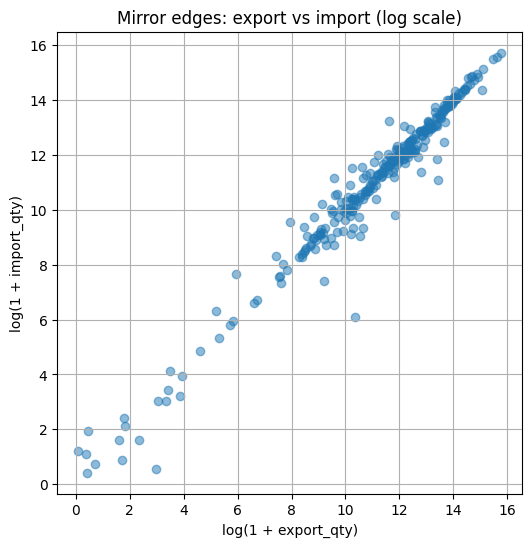

corr(log1p): 0.9824878482097305


In [10]:
m = edges_exp.merge(edges_imp, on=["exporter","importer"], how="inner", suffixes=("_exp","_imp"))
print(len(m))  # 277のはず

import matplotlib.pyplot as plt
import numpy as np

x = m["value_exp"].to_numpy()
y = m["value_imp"].to_numpy()

plt.figure(figsize=(6,6))
plt.scatter(np.log1p(x), np.log1p(y), alpha=0.5)
plt.xlabel("log(1 + export_qty)")
plt.ylabel("log(1 + import_qty)")
plt.title("Mirror edges: export vs import (log scale)")
plt.grid(True)
plt.show()

corr = np.corrcoef(np.log1p(x), np.log1p(y))[0,1]
print("corr(log1p):", corr)


In [13]:
import pandas as pd
import numpy as np

# =========================
# Column names (fixed)
# =========================
REPORTER = "Reporter Countries"
PARTNER  = "Partner Countries"
ITEMCPC  = "Item Code (CPC)"
ELEMENT  = "Element"

# =========================
# Core fetcher
# =========================
def _get_val(df, year, item, element, reporter, partner):
    """
    Sum the FAO value for:
      - ELEMENT == element ("Export quantity" / "Import quantity")
      - reporter / partner match
      - item_code contains `item`
      - year column Y{year}
    """
    ycol = f"Y{year}"
    sub = df.loc[
        (df[ELEMENT].astype(str).str.strip().str.lower() == element.lower()) &
        (df[ITEMCPC].astype(str).str.contains(str(item), na=False)) &
        (df[REPORTER].astype(str) == str(reporter)) &
        (df[PARTNER].astype(str) == str(partner)),
        ycol
    ]
    if sub.empty:
        return 0.0
    return pd.to_numeric(sub, errors="coerce").fillna(0.0).sum()

# =========================
# Pair mirror checker (NO double display)
# =========================
def check_pair_mirror(df, A, B, year=2019, item="'0111"):
    """
    Check both directions for a pair (A,B), keeping the "goods-flow" direction consistent.

    For direction A -> B:
      export(A reports A->B)  vs  import(B reports importing from A)
        = Export qty with (reporter=A, partner=B)
        = Import qty with (reporter=B, partner=A)

    For direction B -> A:
      export(B reports B->A)  vs  import(A reports importing from B)
        = Export qty with (reporter=B, partner=A)
        = Import qty with (reporter=A, partner=B)
    """
    # A -> B
    exp_A_B = _get_val(df, year, item, "Export quantity", reporter=A, partner=B)
    imp_B_from_A = _get_val(df, year, item, "Import quantity", reporter=B, partner=A)

    # B -> A
    exp_B_A = _get_val(df, year, item, "Export quantity", reporter=B, partner=A)
    imp_A_from_B = _get_val(df, year, item, "Import quantity", reporter=A, partner=B)

    out = pd.DataFrame([
        {
            "direction": f"{A} → {B}",
            "export (A reports)": exp_A_B,
            "import (B reports from A)": imp_B_from_A,
            "ratio imp/exp": (imp_B_from_A / exp_A_B) if exp_A_B else np.nan,
            "abs_diff": abs(exp_A_B - imp_B_from_A),
        },
        {
            "direction": f"{B} → {A}",
            "export (B reports)": exp_B_A,
            "import (A reports from B)": imp_A_from_B,
            "ratio imp/exp": (imp_A_from_B / exp_B_A) if exp_B_A else np.nan,
            "abs_diff": abs(exp_B_A - imp_A_from_B),
        },
    ])

    return out

# =========================
# (Optional) helper: search country strings (if names don't match)
# =========================
def search_country(df, keyword, limit=50):
    s = pd.Series(pd.concat([df[REPORTER], df[PARTNER]]).astype(str).unique())
    hits = s[s.str.contains(keyword, case=False, na=False)].sort_values()
    return hits.head(limit).to_list()

# =========================
# Example usage
# =========================
# df = pd.read_pickle("trade_full.pkl")  # if not loaded yet

YEAR = 2019
ITEM = "'0111"   # your CPC filter (contains)

pairs = [
    ("Thailand", "Japan"),
    ("India", "Saudi Arabia"),
    ("United States of America", "Japan"),
]

for A, B in pairs:
    out = check_pair_mirror(df, A, B, year=YEAR, item=ITEM)
    print(f"\n=== {A} vs {B} | year={YEAR} item={ITEM} ===")
    display(out)  # displayed ONCE (no display() inside the function)



=== Thailand vs Japan | year=2019 item='0111 ===


direction  export (A reports)  import (B reports from A)  \
0  Thailand → Japan                0.85                        0.0   
1  Japan → Thailand                 NaN                        NaN   

   ratio imp/exp  abs_diff  export (B reports)  import (A reports from B)  
0            0.0      0.85                 NaN                        NaN  
1            NaN      0.00                 0.0                        0.0


=== India vs Saudi Arabia | year=2019 item='0111 ===


direction  export (A reports)  import (B reports from A)  \
0  India → Saudi Arabia                 0.0                        0.0   
1  Saudi Arabia → India                 NaN                        NaN   

   ratio imp/exp  abs_diff  export (B reports)  import (A reports from B)  
0            NaN       0.0                 NaN                        NaN  
1            NaN       0.0                 0.0                        0.0


=== United States of America vs Japan | year=2019 item='0111 ===


direction  export (A reports)  \
0  United States of America → Japan          2581461.32   
1  Japan → United States of America                 NaN   

   import (B reports from A)  ratio imp/exp  abs_diff  export (B reports)  \
0                  2521155.0       0.976639  60306.32                 NaN   
1                        NaN            NaN      0.00                 0.0   

   import (A reports from B)  
0                        NaN  
1                        0.0

In [14]:
import pandas as pd
import numpy as np

REPORTER = "Reporter Countries"
PARTNER  = "Partner Countries"
ITEMCPC  = "Item Code (CPC)"
ELEMENT  = "Element"

def build_export_edges(df, year=2019, item="'0111"):
    ycol = f"Y{year}"
    d = df[
        df[ITEMCPC].astype(str).str.contains(item, na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("export quantity")
    ][[REPORTER, PARTNER, ycol]].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce").fillna(0.0)
    ex = (d.groupby([REPORTER, PARTNER], as_index=False)[ycol].sum()
            .rename(columns={REPORTER:"exporter", PARTNER:"importer", ycol:"E"}))
    return ex

def build_import_edges_as_goodsflow(df, year=2019, item="'0111"):
    """
    Import quantity:
      reporter = importer
      partner  = exporter
    We convert it to goods-flow direction exporter -> importer.
    """
    ycol = f"Y{year}"
    d = df[
        df[ITEMCPC].astype(str).str.contains(item, na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("import quantity")
    ][[REPORTER, PARTNER, ycol]].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce").fillna(0.0)
    im = (d.groupby([PARTNER, REPORTER], as_index=False)[ycol].sum()
            .rename(columns={PARTNER:"exporter", REPORTER:"importer", ycol:"I"}))
    return im

def pick_bidirectional_pair(ex, im, min_qty=1000):
    """
    Return one strong pair (A,B) such that:
      A->B has E and I, and
      B->A has E and I,
    and each is >= min_qty.
    """
    m = ex.merge(im, on=["exporter","importer"], how="inner")
    m = m[(m["E"] >= min_qty) & (m["I"] >= min_qty)].copy()

    edges = set(zip(m["exporter"], m["importer"]))
    # find pairs with both directions
    candidates = []
    for u, v in edges:
        if (v, u) in edges:
            a, b = sorted([u, v])
            candidates.append((a, b))
    # unique
    candidates = list(dict.fromkeys(candidates))

    if not candidates:
        return None, m

    # score by total magnitude of both directions
    def score_pair(a, b):
        s = 0.0
        for u, v in [(a,b), (b,a)]:
            row = m[(m["exporter"]==u) & (m["importer"]==v)].iloc[0]
            s += float(row["E"] + row["I"])
        return s

    best = max(candidates, key=lambda ab: score_pair(ab[0], ab[1]))
    return best, m

def show_4numbers(ex, im, A, B):
    """
    Display:
      A->B : E(A reports) and I(B reports from A)
      B->A : E(B reports) and I(A reports from B)
    """
    m = ex.merge(im, on=["exporter","importer"], how="outer")

    def get(u, v, col):
        row = m[(m["exporter"]==u) & (m["importer"]==v)]
        if len(row) == 0:
            return 0.0
        val = row[col].iloc[0]
        return 0.0 if pd.isna(val) else float(val)

    rows = []
    for u, v in [(A,B), (B,A)]:
        E = get(u, v, "E")
        I = get(u, v, "I")
        rows.append({
            "direction": f"{u} → {v}",
            "E = Export qty (exporter reports)": E,
            "I = Import qty (importer reports)": I,
            "ratio I/E": (I/E) if E>0 else np.nan,
            "abs_diff": abs(E-I),
        })

    out = pd.DataFrame(rows)
    display(out)
    return out

# ===============================
# RUN (CPC '0111 fixed)
# ===============================
YEAR = 2019
ITEM = "'0111"

ex = build_export_edges(df, year=YEAR, item=ITEM)
im = build_import_edges_as_goodsflow(df, year=YEAR, item=ITEM)

pair, _ = pick_bidirectional_pair(ex, im, min_qty=1000)

print("Picked bidirectional pair:", pair)
if pair is not None:
    A, B = pair
    show_4numbers(ex, im, A, B)
else:
    print("No bidirectional pairs found. Lower min_qty (e.g. 100).")


Picked bidirectional pair: ('Belgium', 'France')


direction  E = Export qty (exporter reports)  \
0  Belgium → France                           46505.61   
1  France → Belgium                         2382030.19   

   I = Import qty (importer reports)  ratio I/E   abs_diff  
0                           42919.29   0.922884    3586.32  
1                         2848849.16   1.195975  466818.97

# Wheatについてのデータづくり

In [15]:
import pandas as pd
import numpy as np

# =========================
# 0) Load
# =========================
df = pd.read_pickle("trade_full.pkl")

# =========================
# 1) Constants
# =========================
REPORTER = "Reporter Countries"
PARTNER  = "Partner Countries"
ITEMCPC  = "Item Code (CPC)"
ELEMENT  = "Element"

# =========================
# 2) Build yearly E/I edges
# =========================
def _prep_export_edges(df, year, item="'0111"):
    """
    Export quantity:
      reporter = exporter
      partner  = importer
    """
    ycol = f"Y{year}"
    d = df.loc[
        df[ITEMCPC].astype(str).str.contains(str(item), na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("export quantity"),
        [REPORTER, PARTNER, ycol]
    ].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    d = d.dropna(subset=[ycol])

    # remove zeros (keeps file smaller; if you want keep, comment out)
    d = d[d[ycol] != 0]

    ex = (d.groupby([REPORTER, PARTNER], as_index=False)[ycol].sum()
            .rename(columns={REPORTER: "exporter", PARTNER: "importer", ycol: "E"}))
    return ex

def _prep_import_edges_goodsflow(df, year, item="'0111"):
    """
    Import quantity in FAO:
      reporter = importer
      partner  = exporter
    Convert to goods-flow:
      exporter = partner
      importer = reporter
    """
    ycol = f"Y{year}"
    d = df.loc[
        df[ITEMCPC].astype(str).str.contains(str(item), na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("import quantity"),
        [REPORTER, PARTNER, ycol]
    ].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    d = d.dropna(subset=[ycol])
    d = d[d[ycol] != 0]

    im = (d.groupby([PARTNER, REPORTER], as_index=False)[ycol].sum()
            .rename(columns={PARTNER: "exporter", REPORTER: "importer", ycol: "I"}))
    return im

# =========================
# 3) Reconcile per year
# =========================
def reconcile_year(df, year, item="'0111"):
    """
    For each pair (exporter, importer) in the year:
      - if both E and I exist: value = (E+I)/2
      - if only one exists: value = that one
      - if none: absent
    Returns:
      exporter, importer, year, value, flag, E, I
    """
    ex = _prep_export_edges(df, year, item=item)
    im = _prep_import_edges_goodsflow(df, year, item=item)

    m = ex.merge(im, on=["exporter", "importer"], how="outer")

    both  = m["E"].notna() & m["I"].notna()
    onlyE = m["E"].notna() & m["I"].isna()
    onlyI = m["E"].isna()  & m["I"].notna()

    m["value"] = np.nan
    m.loc[both,  "value"] = 0.5 * (m.loc[both, "E"] + m.loc[both, "I"])
    m.loc[onlyE, "value"] = m.loc[onlyE, "E"]
    m.loc[onlyI, "value"] = m.loc[onlyI, "I"]

    m["flag"] = np.select(
        [both, onlyE, onlyI],
        ["mean(E,I)", "only_export_report", "only_import_report"],
        default="none"
    )

    out = m.loc[m["value"].notna(), ["exporter", "importer", "value", "flag", "E", "I"]].copy()
    out["year"] = year
    return out.reset_index(drop=True)

# =========================
# 4) 2009–2011 average (ignore missing years)
# =========================
def reconcile_and_average(df, years=(2009, 2010, 2011), item="'0111"):
    yearly = pd.concat([reconcile_year(df, y, item=item) for y in years], ignore_index=True)

    avg = (yearly.groupby(["exporter", "importer"], as_index=False)["value"]
                 .mean()
                 .rename(columns={"value": f"value_mean_{years[0]}_{years[-1]}"}))
    return avg, yearly

# =========================
# 5) Run + Save
# =========================
ITEM  = "'0111"
YEARS = (2009, 2010, 2011)

avg_3yr, yearly_detail = reconcile_and_average(df, years=YEARS, item=ITEM)

# quick sanity
print("yearly rows:", len(yearly_detail))
print("avg pairs:", len(avg_3yr))
display(avg_3yr.head(20))
display(yearly_detail.head(20))

# Save to CSV
avg_path = f"cpc0111_export_reconciled_mean_{YEARS[0]}_{YEARS[-1]}.csv"
yr_path  = f"cpc0111_export_reconciled_yearly_{YEARS[0]}_{YEARS[-1]}.csv"

avg_3yr.to_csv(avg_path, index=False)
yearly_detail.to_csv(yr_path, index=False)

print("Saved:", avg_path)
print("Saved:", yr_path)


yearly rows: 4803
avg pairs: 2406


exporter                          importer  \
0           Afghanistan                           Morocco   
1               Albania                            Serbia   
2               Algeria                            Canada   
3                Angola                            Brazil   
4   Antigua and Barbuda                        Madagascar   
5             Argentina                           Algeria   
6             Argentina                           Bahrain   
7             Argentina                        Bangladesh   
8             Argentina                           Belgium   
9             Argentina  Bolivia (Plurinational State of)   
10            Argentina                            Brazil   
11            Argentina                      Burkina Faso   
12            Argentina                           Burundi   
13            Argentina                        Cabo Verde   
14            Argentina                          Cameroon   
15            Argentina                            Canada   
16            Argentina                             Chile   
17            Argentina              China, Hong Kong SAR   
18            Argentina         China, Taiwan Province of   
19            Argentina                          Colombia   

    value_mean_2009_2011  
0           6.929600e+04  
1           8.700000e+01  
2           1.330000e+02  
3           1.000500e+04  
4           5.000000e+02  
5           2.437020e+05  
6           4.019800e+04  
7           1.973640e+05  
8           8.890000e+02  
9           3.943700e+04  
10          3.800664e+06  
11          6.747000e+03  
12          3.000000e+03  
13          4.500000e+03  
14          1.338333e+04  
15          1.000000e+00  
16          7.890067e+04  
17          4.000000e+00  
18          2.300000e+01  
19          2.129075e+05

exporter                          importer      value  \
0   Afghanistan                           Morocco    69296.0   
1       Algeria                            Canada      133.0   
2     Argentina                           Belgium      256.5   
3     Argentina  Bolivia (Plurinational State of)    29057.5   
4     Argentina                            Brazil  3292675.0   
5     Argentina                          Cameroon     8440.0   
6     Argentina                             Chile    98554.5   
7     Argentina         China, Taiwan Province of       23.0   
8     Argentina                          Colombia   304685.5   
9     Argentina                             Congo     9300.0   
10    Argentina  Democratic Republic of the Congo     8881.0   
11    Argentina                           Ecuador     4785.0   
12    Argentina                             Egypt    13400.0   
13    Argentina                            France      307.5   
14    Argentina                             Haiti    19936.0   
15    Argentina        Iran (Islamic Republic of)   291398.0   
16    Argentina                            Israel      101.0   
17    Argentina                             Italy      151.0   
18    Argentina                             Kenya    69902.0   
19    Argentina                        Madagascar    20941.5   

                  flag          E          I  year  
0   only_import_report        NaN    69296.0  2009  
1   only_import_report        NaN      133.0  2009  
2            mean(E,I)      339.0      174.0  2009  
3            mean(E,I)    27929.0    30186.0  2009  
4            mean(E,I)  3370038.0  3215312.0  2009  
5            mean(E,I)     4530.0    12350.0  2009  
6            mean(E,I)    62220.0   134889.0  2009  
7   only_import_report        NaN       23.0  2009  
8            mean(E,I)   303305.0   306066.0  2009  
9   only_import_report        NaN     9300.0  2009  
10  only_export_report     8881.0        NaN  2009  
11           mean(E,I)     5176.0     4394.0  2009  
12  only_import_report        NaN    13400.0  2009  
13           mean(E,I)      308.0      307.0  2009  
14  only_export_report    19936.0        NaN  2009  
15  only_export_report   291398.0        NaN  2009  
16           mean(E,I)      108.0       94.0  2009  
17           mean(E,I)      151.0      151.0  2009  
18           mean(E,I)    67095.0    72709.0  2009  
19           mean(E,I)    22000.0    19883.0  2009

Saved: cpc0111_export_reconciled_mean_2009_2011.csv
Saved: cpc0111_export_reconciled_yearly_2009_2011.csv


In [17]:

# --- あなたの pivot（ここはそのまま）
mat = avg_3yr.pivot_table(
    index="exporter",
    columns="importer",
    values="value_mean_2009_2011",
    fill_value=0.0
)

# =========================
# 保存（追加する部分）
# =========================

YEARS = (2009, 2010, 2011)
ITEM  = "'0111"

# 1) 行列CSV（Excelでも見れる）
mat_csv_path = f"cpc0111_matrix_mean_{YEARS[0]}_{YEARS[-1]}.csv"
mat.to_csv(mat_csv_path)

# 2) 行列pickle（次回すぐ読むため）
mat_pkl_path = f"cpc0111_matrix_mean_{YEARS[0]}_{YEARS[-1]}.pkl"
mat.to_pickle(mat_pkl_path)

# 3) （任意）parquet（小さくて高速・pyarrow必要）
try:
    mat_parquet_path = f"cpc0111_matrix_mean_{YEARS[0]}_{YEARS[-1]}.parquet"
    mat.to_parquet(mat_parquet_path)
    parquet_ok = True
except Exception as e:
    parquet_ok = False
    print("Parquet save skipped (pyarrow not installed?):", e)

print("Saved matrix CSV :", mat_csv_path)
print("Saved matrix PKL :", mat_pkl_path)
if parquet_ok:
    print("Saved matrix Parquet:", mat_parquet_path)

# 4) ちょい確認
print("matrix shape:", mat.shape)
print("nonzero links:", int((mat.values > 0).sum()))
display(mat.iloc[:10, :10])


Saved matrix CSV : cpc0111_matrix_mean_2009_2011.csv
Saved matrix PKL : cpc0111_matrix_mean_2009_2011.pkl
Saved matrix Parquet: cpc0111_matrix_mean_2009_2011.parquet
matrix shape: (138, 183)
nonzero links: 2406


importer             Afghanistan  Albania   Algeria  Angola  \
exporter                                                      
Afghanistan                  0.0      0.0       0.0     0.0   
Albania                      0.0      0.0       0.0     0.0   
Algeria                      0.0      0.0       0.0     0.0   
Angola                       0.0      0.0       0.0     0.0   
Antigua and Barbuda          0.0      0.0       0.0     0.0   
Argentina                    0.0      0.0  243702.0     0.0   
Armenia                      0.0      0.0       0.0     0.0   
Australia                    0.0      0.0   36026.0     0.0   
Austria                      0.0      0.0       0.0     0.0   
Azerbaijan                  88.0      0.0       0.0     0.0   

importer             Antigua and Barbuda  Argentina  Armenia  Australia  \
exporter                                                                  
Afghanistan                          0.0        0.0      0.0        0.0   
Albania                              0.0        0.0      0.0        0.0   
Algeria                              0.0        0.0      0.0        0.0   
Angola                               0.0        0.0      0.0        0.0   
Antigua and Barbuda                  0.0        0.0      0.0        0.0   
Argentina                            0.0        0.0      0.0        0.0   
Armenia                              0.0        0.0      0.0        0.0   
Australia                            0.0        0.0     49.0       47.0   
Austria                              0.0        0.0      0.0        5.0   
Azerbaijan                           0.0        0.0      0.0        0.0   

importer             Austria  Azerbaijan  
exporter                                  
Afghanistan              0.0         0.0  
Albania                  0.0         0.0  
Algeria                  0.0         0.0  
Angola                   0.0         0.0  
Antigua and Barbuda      0.0         0.0  
Argentina                0.0         0.0  
Armenia                  0.0         0.0  
Australia                0.0         0.0  
Austria                  0.0         0.0  
Azerbaijan               0.0         0.0

# 行列読み込み時は以下のコード

In [46]:
mat = pd.read_pickle("cpc0111_matrix_mean_2009_2011.pkl")
# または
#mat = pd.read_csv("cpc0111_matrix_mean_2009_2011.csv", index_col=0)


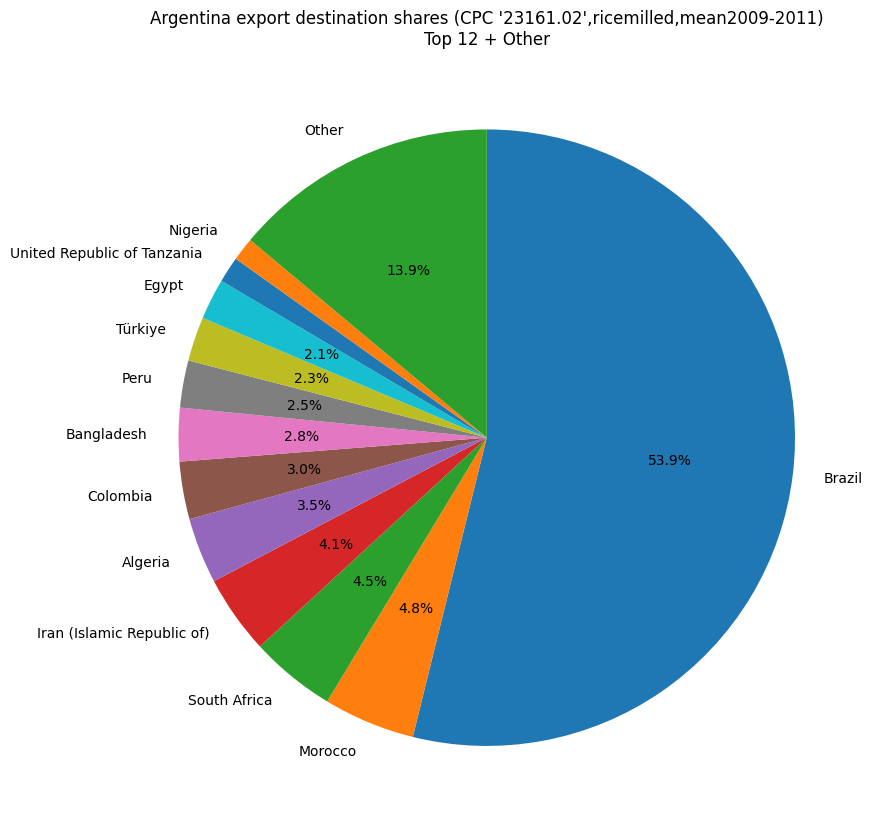

share  share_pct
Brazil                       0.538571  53.857060
Other                        0.139203  13.920284
Morocco                      0.048038   4.803792
South Africa                 0.045002   4.500247
Iran (Islamic Republic of)   0.041292   4.129237
Algeria                      0.034534   3.453364
Colombia                     0.030170   3.016992
Bangladesh                   0.027967   2.796734
Peru                         0.024742   2.474246
Türkiye                      0.023180   2.318007
Egypt                        0.021458   2.145820
United Republic of Tanzania  0.013618   1.361781
Nigeria                      0.012224   1.222436

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
EXPORTER = "Argentina"     # ← FAO表記に合わせて変える（候補検索も下に用意）
TOPK = 12                  # 上位何カ国まで円グラフに出すか（残りはOtherへ）
MIN_SHARE = 0.01           # 1%未満はOtherへ（TOPKと併用）

# =========================
# Helper: country name search
# =========================
def search_exporter_name(mat, keyword="argen"):
    idx = pd.Index(mat.index.astype(str))
    return idx[idx.str.contains(keyword, case=False, na=False)].tolist()

# もし名前がヒットしない時は：
# print(search_exporter_name(mat, "argen"))

# =========================
# 1) Extract exporter row
# =========================
if EXPORTER not in mat.index:
    raise ValueError(f"Exporter '{EXPORTER}' not found. Try: search_exporter_name(mat, 'argen')")

row = mat.loc[EXPORTER].copy()

# remove self-loop if exists
if EXPORTER in row.index:
    row.loc[EXPORTER] = 0.0

# keep positive only
row = row[row > 0].sort_values(ascending=False)

total = row.sum()
if total <= 0:
    raise ValueError(f"No positive exports found for {EXPORTER}.")

share = (row / total).sort_values(ascending=False)

# =========================
# 2) Aggregate to TopK + Other
# =========================
share_filtered = share.copy()

# apply MIN_SHARE first
small = share_filtered[share_filtered < MIN_SHARE]
share_filtered = share_filtered[share_filtered >= MIN_SHARE]

# ensure at most TOPK items
if len(share_filtered) > TOPK:
    top = share_filtered.iloc[:TOPK]
    rest = share_filtered.iloc[TOPK:]
    other_share = rest.sum() + small.sum()
    share_plot = pd.concat([top, pd.Series({"Other": other_share})])
else:
    other_share = small.sum()
    if other_share > 0:
        share_plot = pd.concat([share_filtered, pd.Series({"Other": other_share})])
    else:
        share_plot = share_filtered

# normalize (just in case numerical issues)
share_plot = share_plot / share_plot.sum()

# =========================
# 3) Plot pie chart
# =========================
labels = share_plot.index.tolist()
sizes  = share_plot.values

plt.figure(figsize=(9, 9))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%" if p >= 2 else "",  # small slices no label
    startangle=90,
    counterclock=False
)
plt.title(f"{EXPORTER} export destination shares (CPC '23161.02',ricemilled,mean2009-2011)\nTop {TOPK} + Other")
plt.tight_layout()
plt.show()

# =========================
# 4) Print table (for sanity)
# =========================
out_table = (share_plot.rename("share")
             .to_frame()
             .assign(share_pct=lambda d: 100*d["share"])
             .sort_values("share", ascending=False))

display(out_table)


Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
Edges (pre-drop): 503
Edges (after drop): 412
Dropped due to missing coords (showing up to 20):
['Albania' 'Antigua and Barbuda' 'Australia' 'Bahrain' 'Barbados'
 'Belgium' 'Bosnia and Herzegovina' 'Cabo Verde' 'China, Hong Kong SAR'
 'China, mainland' 'Colombia' 'Congo' "Côte d'Ivoire" 'Denmark' 'Dominica'
 'Egypt' 'Estonia' 'Eswatini' 'Ethiopia' 'France']


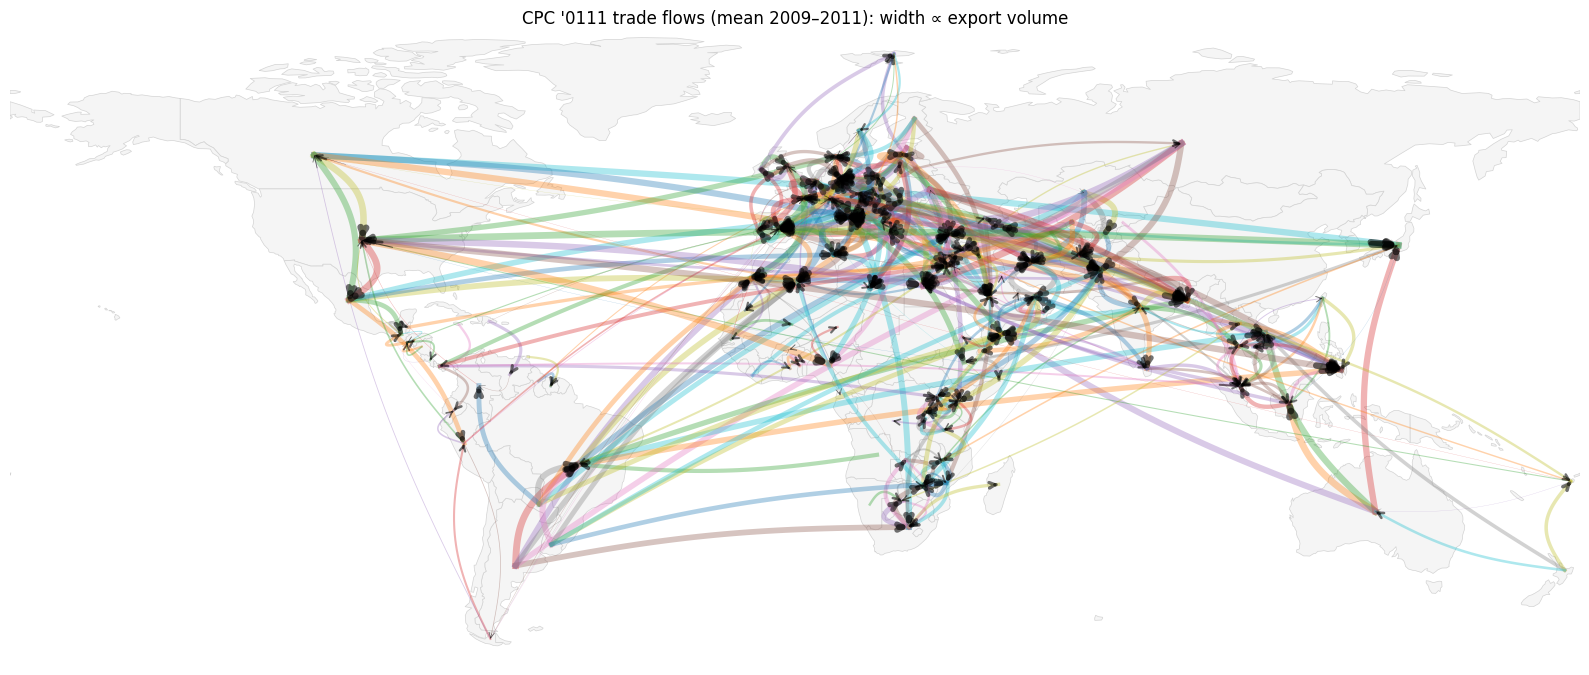

Saved: cpc0111_arrows_widthprop.png


In [23]:
import os
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


# =========================
# 1) Download Natural Earth countries (Admin 0)
# =========================
def load_naturalearth_admin0_countries(scale="110m", cache_dir=None):
    """
    Download and load Natural Earth admin 0 countries shapefile.
    Returns GeoDataFrame with a country name column.
    """
    if cache_dir is None:
        cache_dir = os.path.expanduser("~/.cache/naturalearth")
    os.makedirs(cache_dir, exist_ok=True)

    # Natural Earth admin0 countries
    # Official-looking stable mirror (naciscdn)
    url = f"https://naciscdn.org/naturalearth/{scale}/cultural/ne_{scale}_admin_0_countries.zip"
    zip_path = os.path.join(cache_dir, f"ne_{scale}_admin_0_countries.zip")
    extract_dir = os.path.join(cache_dir, f"ne_{scale}_admin_0_countries")

    if not os.path.exists(zip_path):
        print("Downloading:", url)
        urllib.request.urlretrieve(url, zip_path)

    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_dir)

    # find .shp
    shp_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith(".shp")]
    if not shp_files:
        raise RuntimeError(f"No .shp found in {extract_dir}")
    shp_path = shp_files[0]

    world = gpd.read_file(shp_path)

    # choose name column (Natural Earth usually has ADMIN, NAME, NAME_EN, etc.)
    name_col = None
    for c in ["ADMIN", "NAME_EN", "NAME", "SOVEREIGNT", "FORMAL_EN", "BRK_NAME"]:
        if c in world.columns:
            name_col = c
            break
    if name_col is None:
        raise RuntimeError(f"No country name column found. Columns: {list(world.columns)}")

    world = world.rename(columns={name_col: "name"})
    return world


# =========================
# 2) Matrix -> edges (top N per exporter)
# =========================
def mat_to_edges_topN(mat: pd.DataFrame, topN_per_exporter=5, min_value=0.0):
    edges = []
    for exporter, row in mat.iterrows():
        s = row[row > min_value].sort_values(ascending=False)
        if len(s) == 0:
            continue
        if topN_per_exporter is not None:
            s = s.head(topN_per_exporter)
        edges.append(pd.DataFrame({
            "exporter": exporter,
            "importer": s.index.astype(str),
            "value": s.values
        }))
    if not edges:
        return pd.DataFrame(columns=["exporter", "importer", "value"])
    return pd.concat(edges, ignore_index=True)


# =========================
# 3) Country centroids + name lookup
# =========================
def build_coord_lookup_from_world(world_gdf, extra_alias=None):
    # representative point is safer than centroid
    world = world_gdf.copy()
    world["pt"] = world.geometry.representative_point()
    world["lon"] = world["pt"].x
    world["lat"] = world["pt"].y

    coords = {r["name"]: (float(r["lon"]), float(r["lat"])) for _, r in world[["name","lon","lat"]].iterrows()}

    # FAO → NaturalEarth name fixes（必要に応じて増やす）
    alias = {
        "United States of America": "United States of America",
        "Russian Federation": "Russia",
        "Viet Nam": "Vietnam",
        "Iran (Islamic Republic of)": "Iran",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Syrian Arab Republic": "Syria",
        "Türkiye": "Turkey",
        "Czechia": "Czech Republic",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Lao People's Democratic Republic": "Laos",
        "Korea, Rep.": "South Korea",
        "Korea, Dem. People's Rep.": "North Korea",
        "China, Hong Kong SAR": "Hong Kong",
        "China, Macao SAR": "Macao",
        "China, Taiwan Province of": "Taiwan",
        "Democratic Republic of the Congo": "Dem. Rep. Congo",
    }
    if extra_alias:
        alias.update(extra_alias)

    def lookup(name):
        if name in coords:
            return coords[name]
        if name in alias and alias[name] in coords:
            return coords[alias[name]]
        return None

    return lookup


# =========================
# 4) Curved arrow line
# =========================
def curved_line(lon1, lat1, lon2, lat2, curvature=0.25, n=40):
    t = np.linspace(0, 1, n)
    x = (1 - t) * lon1 + t * lon2
    y = (1 - t) * lat1 + t * lat2

    dx = lon2 - lon1
    dy = lat2 - lat1
    px, py = -dy, dx
    norm = np.hypot(px, py) + 1e-9
    px, py = px / norm, py / norm

    bump = curvature * np.sin(np.pi * t)
    x = x + bump * px * 20
    y = y + bump * py * 10
    return np.c_[x, y]


# =========================
# 5) Plot
# =========================
def plot_trade_arrows_world(
    mat,
    topN_per_exporter=5,
    min_value=0.0,
    width_min=0.2,
    width_max=5.0,
    use_log_width=True,
    curvature=0.25,
    figsize=(16, 9),
    title="Trade flows",
    out_png="trade_arrows.png",
    ne_scale="110m",  # 110m is light; 50m/10m are heavier
):
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(world)

    edges = mat_to_edges_topN(mat, topN_per_exporter=topN_per_exporter, min_value=min_value)
    print("Edges (pre-drop):", len(edges))

    def get_lonlat(country):
        ll = lookup(country)
        if ll is None:
            return (np.nan, np.nan)
        return ll

    edges[["lon1","lat1"]] = edges["exporter"].apply(lambda x: pd.Series(get_lonlat(x)))
    edges[["lon2","lat2"]] = edges["importer"].apply(lambda x: pd.Series(get_lonlat(x)))

    missing = edges[edges[["lon1","lat1","lon2","lat2"]].isna().any(axis=1)]
    edges = edges.dropna(subset=["lon1","lat1","lon2","lat2"]).copy()
    print("Edges (after drop):", len(edges))
    if len(missing) > 0:
        print("Dropped due to missing coords (showing up to 20):")
        print(pd.unique(pd.concat([missing["exporter"], missing["importer"]]).dropna())[:20])

    # widths proportional to export volume (normalized)
    v = edges["value"].astype(float).values
    v_use = np.log1p(v) if use_log_width else v
    vmin, vmax = float(np.min(v_use)), float(np.max(v_use))
    if vmax == vmin:
        widths = np.full(len(edges), (width_min + width_max) / 2.0)
    else:
        widths = width_min + (v_use - vmin) * (width_max - width_min) / (vmax - vmin)

    fig, ax = plt.subplots(figsize=figsize)
    world.plot(ax=ax, color="whitesmoke", edgecolor="lightgray", linewidth=0.5)

    for (lon1,lat1,lon2,lat2,w) in zip(edges["lon1"],edges["lat1"],edges["lon2"],edges["lat2"],widths):
        pts = curved_line(lon1, lat1, lon2, lat2, curvature=curvature, n=40)
        ax.plot(pts[:,0], pts[:,1], linewidth=float(w), alpha=0.35)
        ax.annotate(
            "", xy=(pts[-1,0], pts[-1,1]), xytext=(pts[-2,0], pts[-2,1]),
            arrowprops=dict(arrowstyle="->", lw=float(w), alpha=0.55, shrinkA=0, shrinkB=0)
        )

    ax.set_title(title)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 85)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()
    print("Saved:", out_png)


# =========================
# RUN (おすすめ設定)
# =========================
plot_trade_arrows_world(
    mat,
    topN_per_exporter=5,
    min_value=0.0,        # 真っ黒なら 1000 / 10000 など上げる
    width_min=0.2,
    width_max=5.0,
    use_log_width=True,
    title="CPC '0111 trade flows (mean 2009–2011): width ∝ export volume",
    out_png="cpc0111_arrows_widthprop.png",
    ne_scale="110m"
)


# 中国のデータない？

focus edges: 41


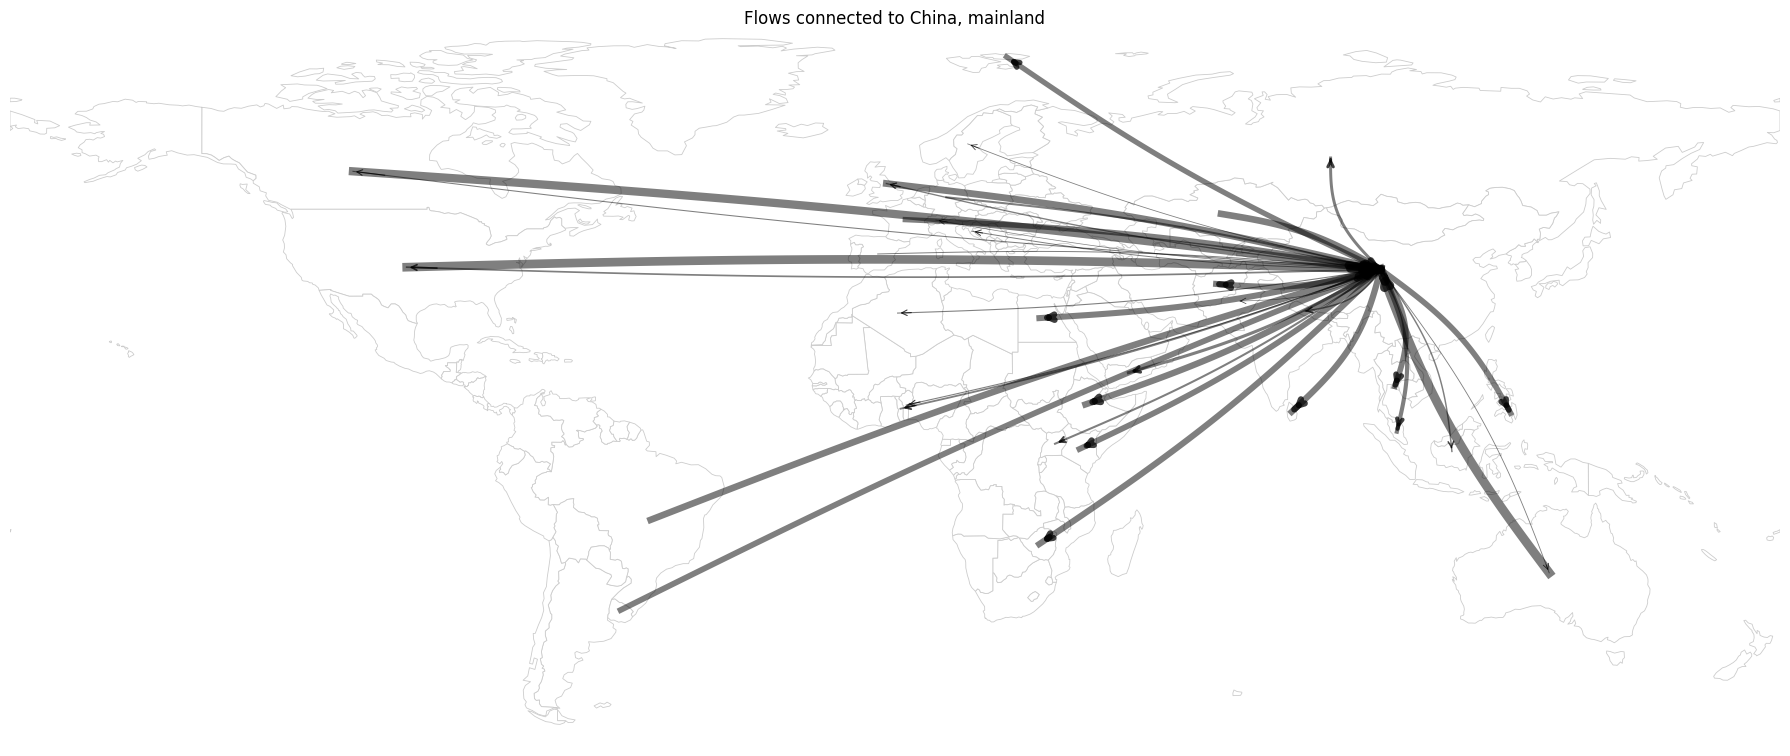

Saved: china_flows.png


In [25]:
def plot_filtered(mat, focus="China, mainland", topN=30, title=None, out_png="focus.png"):
    # focus国の輸出 topN + 輸入 topN だけ
    row = mat.loc[focus].sort_values(ascending=False).head(topN) if focus in mat.index else pd.Series(dtype=float)
    col = mat[focus].sort_values(ascending=False).head(topN) if focus in mat.columns else pd.Series(dtype=float)

    edges = []
    for imp, v in row.items():
        if v > 0:
            edges.append((focus, imp, float(v)))
    for exp, v in col.items():
        if v > 0:
            edges.append((exp, focus, float(v)))

    edges = pd.DataFrame(edges, columns=["exporter","importer","value"])
    print("focus edges:", len(edges))
    return plot_edges_world(edges, title=title or f"Flows connected to {focus}", out_png=out_png)

# edges を直接描く版（mat版じゃなく）
def plot_edges_world(edges_df, title="flows", out_png="edges.png", ne_scale="110m"):
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(world, extra_alias={"China, mainland":"China"})

    def get_ll(x):
        ll = lookup(x)
        return (np.nan, np.nan) if ll is None else ll

    edges = edges_df.copy()
    edges[["lon1","lat1"]] = edges["exporter"].apply(lambda x: pd.Series(get_ll(x)))
    edges[["lon2","lat2"]] = edges["importer"].apply(lambda x: pd.Series(get_ll(x)))
    edges = edges.dropna()

    v = edges["value"].values
    v_use = np.log1p(v)
    widths = 0.5 + 6*(v_use - v_use.min())/(v_use.max()-v_use.min()+1e-9)

    fig, ax = plt.subplots(figsize=(18,9))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6)
    for (lon1,lat1,lon2,lat2,w) in zip(edges["lon1"],edges["lat1"],edges["lon2"],edges["lat2"],widths):
        pts = curved_line(lon1,lat1,lon2,lat2,curvature=0.18,n=60)
        ax.plot(pts[:,0], pts[:,1], lw=float(w), alpha=0.5, color="black")
        ax.annotate("", xy=(pts[-1,0],pts[-1,1]), xytext=(pts[-3,0],pts[-3,1]),
                    arrowprops=dict(arrowstyle="->", lw=float(w), alpha=0.75, color="black"))
    ax.set_xlim(-180,180); ax.set_ylim(-60,85); ax.axis("off"); ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=220); plt.show()
    print("Saved:", out_png)

# 実行例（中国周りだけ）
plot_filtered(mat, focus="China, mainland", topN=30, out_png="china_flows.png")


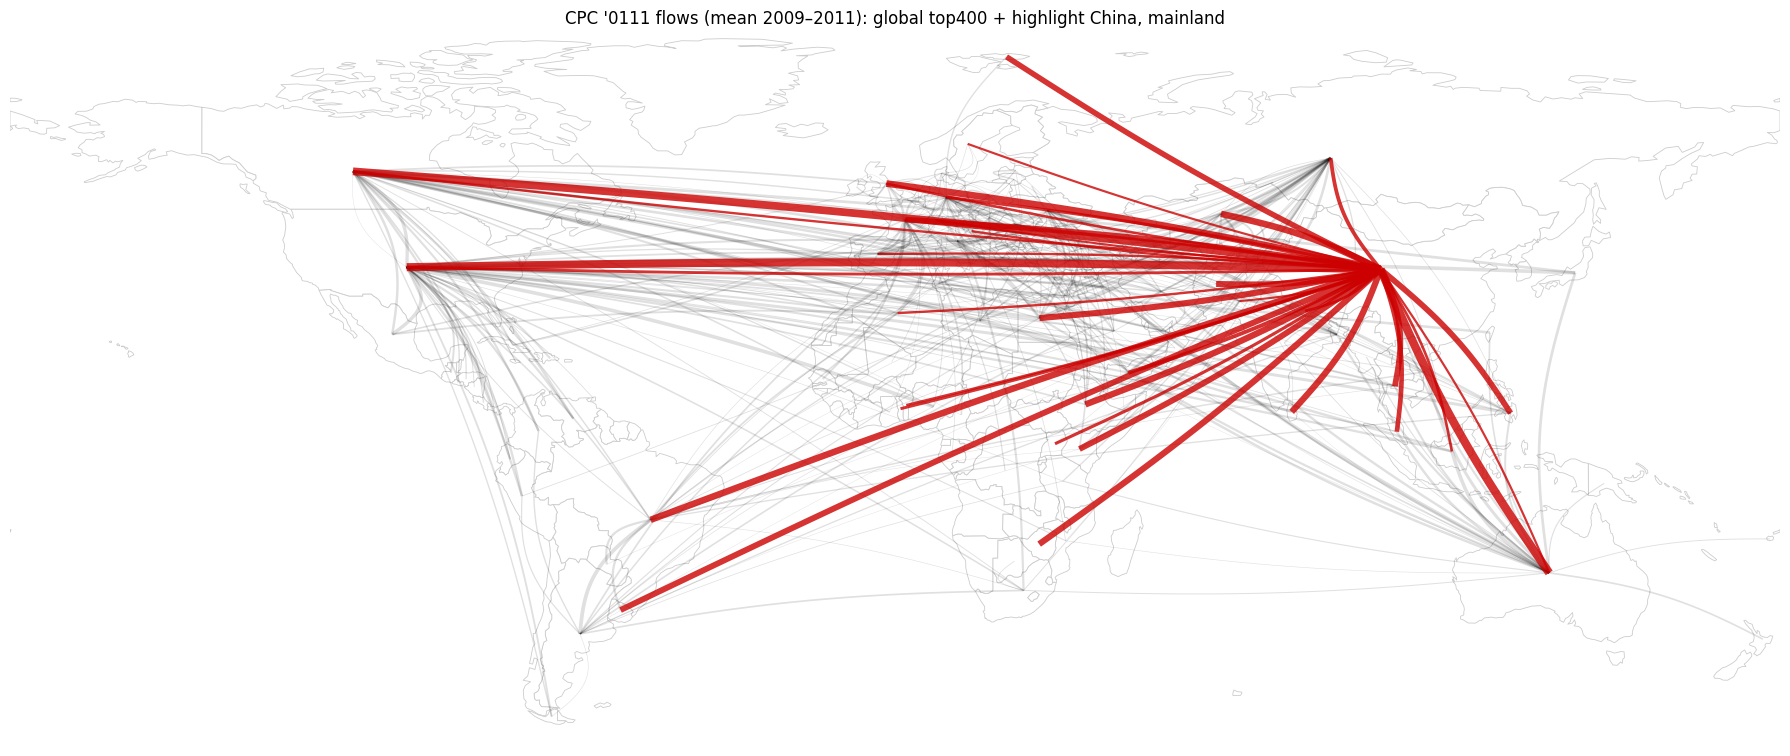

Saved: world_focus.png


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.collections import LineCollection

def mat_to_edges_all(mat, min_value=0.0):
    df = mat.stack().reset_index()
    df.columns = ["exporter","importer","value"]
    df = df[df["value"] > min_value].copy()
    return df

def plot_world_with_focus(mat, focus="China, mainland",
                          topK_global=400,  # 世界は上位K本だけ
                          topK_focus=80,    # focus関連は上位K本
                          min_value=0.0,
                          ne_scale="110m",
                          out_png="world_focus.png"):

    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(world, extra_alias={"China, mainland":"China"})

    # edges (global)
    edges = mat_to_edges_all(mat, min_value=min_value)
    edges = edges.sort_values("value", ascending=False).head(topK_global)

    # focus edges (connected to focus) — globalとは別枠で足す
    focus_edges = mat_to_edges_all(mat, min_value=min_value)
    focus_edges = focus_edges[(focus_edges["exporter"]==focus) | (focus_edges["importer"]==focus)]
    focus_edges = focus_edges.sort_values("value", ascending=False).head(topK_focus)

    def get_ll(x):
        ll = lookup(x)
        return (np.nan, np.nan) if ll is None else ll

    def build_segments(df, curvature=0.18):
        df = df.copy()
        df[["lon1","lat1"]] = df["exporter"].apply(lambda x: pd.Series(get_ll(x)))
        df[["lon2","lat2"]] = df["importer"].apply(lambda x: pd.Series(get_ll(x)))
        df = df.dropna()
        segs = [curved_line(r.lon1,r.lat1,r.lon2,r.lat2,curvature=curvature,n=50)
                for r in df.itertuples(index=False)]
        return df, segs

    edges, segs = build_segments(edges, curvature=0.22)
    focus_edges, focus_segs = build_segments(focus_edges, curvature=0.12)

    # width scale
    def scale_width(v, wmin, wmax):
        v = np.log1p(v)
        return wmin + (v - v.min()) * (wmax - wmin) / (v.max() - v.min() + 1e-9)

    w_global = scale_width(edges["value"].values, 0.3, 2.8)
    w_focus  = scale_width(focus_edges["value"].values, 1.5, 6.0)

    fig, ax = plt.subplots(figsize=(18,9))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    # global: thin & light gray
    lc = LineCollection(segs, linewidths=w_global, colors=[(0,0,0,0.12)]*len(segs), zorder=2)
    ax.add_collection(lc)

    # focus: thick & dark (red)
    lc2 = LineCollection(focus_segs, linewidths=w_focus, colors=[(0.8,0,0,0.8)]*len(focus_segs), zorder=3)
    ax.add_collection(lc2)

    ax.set_xlim(-180,180); ax.set_ylim(-60,85); ax.axis("off")
    ax.set_title(f"CPC '0111 flows (mean 2009–2011): global top{topK_global} + highlight {focus}")
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

# 実行
plot_world_with_focus(mat, focus="China, mainland", topK_global=400, topK_focus=100, min_value=0.0)


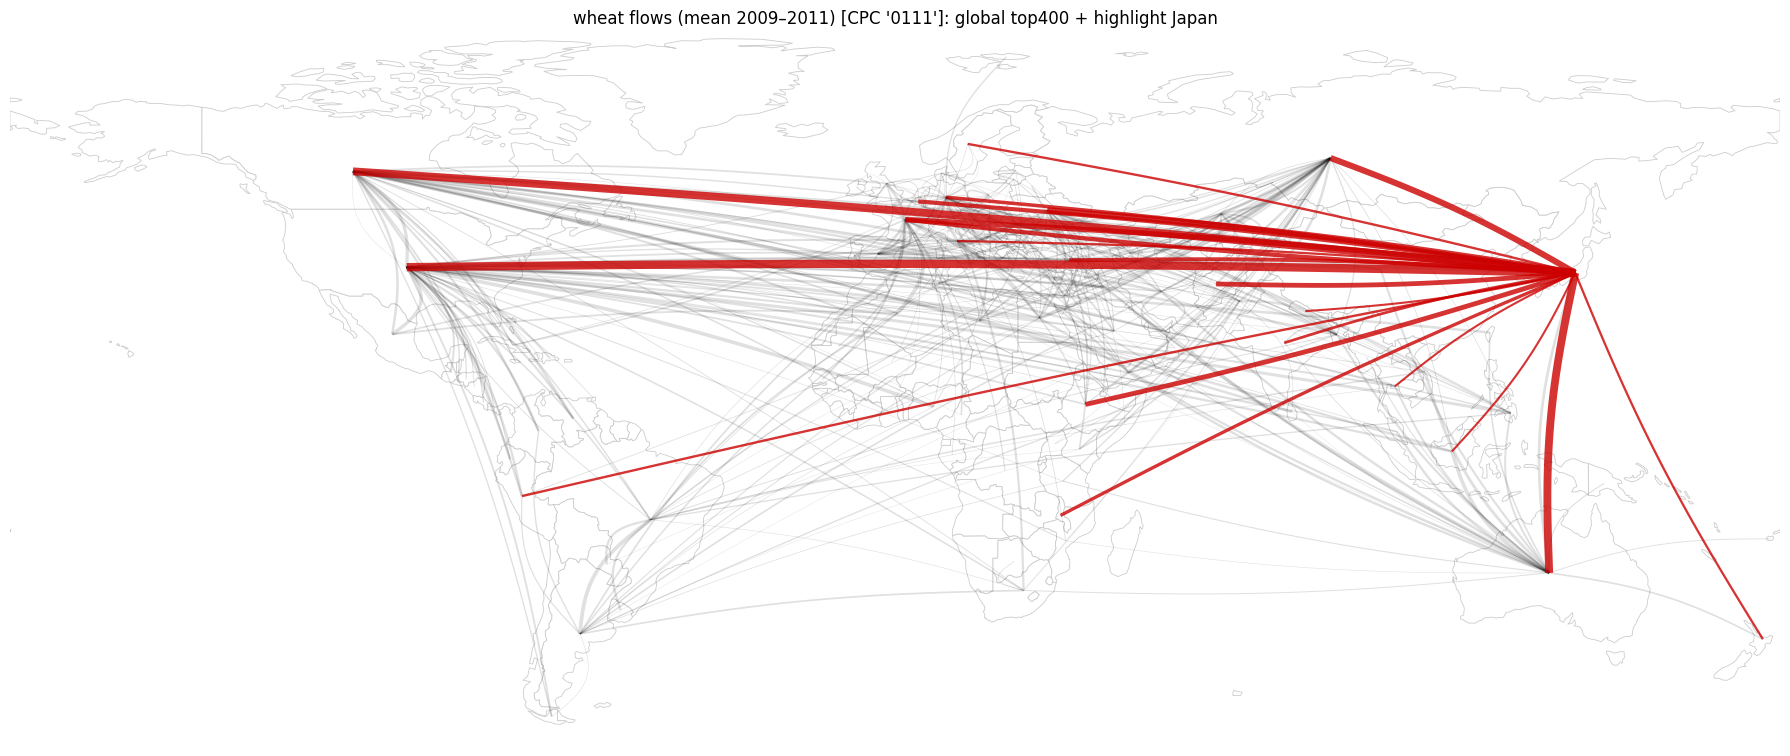

Saved: world_focus_Japan_wheat.png


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.collections import LineCollection

# =========================================
# IMPORTANT:
# You must already have these functions defined in your notebook:
#   - load_naturalearth_admin0_countries(scale="110m" or "50m")
#   - build_coord_lookup_from_world(world_gdf, extra_alias=None)
#   - curved_line(lon1, lat1, lon2, lat2, curvature=..., n=...)
# =========================================


def mat_to_edges_all(mat, min_value=0.0):
    """
    Convert exporter x importer matrix -> edges table
    """
    df = mat.stack().reset_index()
    df.columns = ["exporter", "importer", "value"]
    df = df[df["value"] > min_value].copy()
    return df


def plot_world_with_focus(
    mat,
    focus="Japan",
    topK_global=400,   # 世界は上位K本だけ
    topK_focus=80,     # focus関連は上位K本
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus.png",
    crop_label="wheat",     # ← 表示用
    cpc_label="0111",       # ← 表示用
):
    """
    Plot global topK edges + highlight edges connected to `focus`.
    - Global edges: thin light gray
    - Focus edges: thick red
    """

    # world shapes
    world = load_naturalearth_admin0_countries(scale=ne_scale)

    # name lookup (FAO name -> Natural Earth name)
    lookup = build_coord_lookup_from_world(
        world,
        extra_alias={
            "China, mainland": "China",
            "Viet Nam": "Vietnam",
            "Russian Federation": "Russia",
            "United States of America": "United States of America",
            "Japan": "Japan",
        }
    )

    # --- edges (global) ---
    edges = mat_to_edges_all(mat, min_value=min_value)
    edges = edges.sort_values("value", ascending=False).head(topK_global)

    # --- focus edges (connected to focus) ---
    focus_edges = mat_to_edges_all(mat, min_value=min_value)
    focus_edges = focus_edges[
        (focus_edges["exporter"] == focus) | (focus_edges["importer"] == focus)
    ]
    focus_edges = focus_edges.sort_values("value", ascending=False).head(topK_focus)

    def get_ll(x):
        ll = lookup(str(x))
        return (np.nan, np.nan) if ll is None else ll

    def build_segments(df, curvature=0.18):
        df = df.copy()
        df[["lon1", "lat1"]] = df["exporter"].apply(lambda x: pd.Series(get_ll(x)))
        df[["lon2", "lat2"]] = df["importer"].apply(lambda x: pd.Series(get_ll(x)))
        df = df.dropna()

        segs = [
            curved_line(r.lon1, r.lat1, r.lon2, r.lat2, curvature=curvature, n=50)
            for r in df.itertuples(index=False)
        ]
        return df, segs

    # build curves
    edges, segs = build_segments(edges, curvature=0.22)
    focus_edges, focus_segs = build_segments(focus_edges, curvature=0.12)

    # width scaling (log)
    def scale_width(v, wmin, wmax):
        v = np.log1p(v)
        return wmin + (v - v.min()) * (wmax - wmin) / (v.max() - v.min() + 1e-9)

    w_global = scale_width(edges["value"].values, 0.3, 2.8)
    w_focus  = scale_width(focus_edges["value"].values, 1.5, 6.0)

    # plot
    fig, ax = plt.subplots(figsize=(18, 9))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    # global: thin & light gray
    lc = LineCollection(
        segs,
        linewidths=w_global,
        colors=[(0, 0, 0, 0.12)] * len(segs),
        zorder=2
    )
    ax.add_collection(lc)

    # focus: thick red
    lc2 = LineCollection(
        focus_segs,
        linewidths=w_focus,
        colors=[(0.8, 0, 0, 0.8)] * len(focus_segs),
        zorder=3
    )
    ax.add_collection(lc2)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 85)
    ax.axis("off")

    # TITLE: show wheat instead of CPC code
    ax.set_title(
        f"{crop_label} flows (mean 2009–2011) [CPC '{cpc_label}']: "
        f"global top{topK_global} + highlight {focus}"
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()

    print("Saved:", out_png)

    return edges, focus_edges


# =========================
# RUN (Japan focus)
# =========================
edges_global, edges_japan = plot_world_with_focus(
    mat,
    focus="Japan",
    topK_global=400,
    topK_focus=100,
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus_Japan_wheat.png",
    crop_label="wheat",
    cpc_label="0111",
)


Global edges plotted: 372
Japan EXPORT edges plotted: 5
Japan IMPORT edges plotted: 16


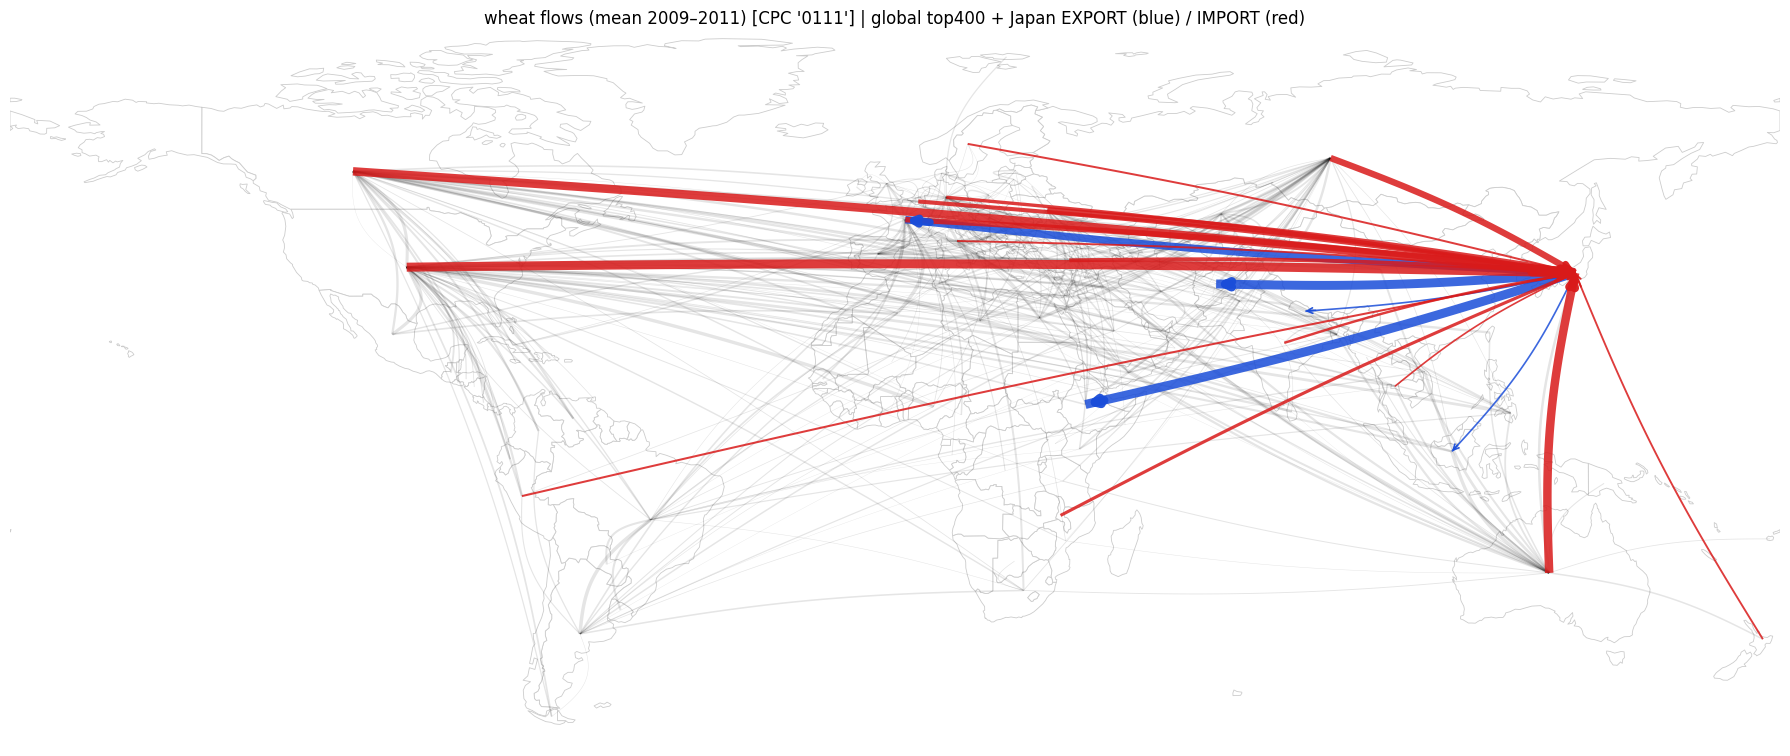

Saved: world_focus_Japan_wheat_export_import.png


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# =========================================
# Required pre-defined functions in your notebook:
#   - load_naturalearth_admin0_countries(scale="110m" or "50m")
#   - build_coord_lookup_from_world(world_gdf, extra_alias=None)
#   - curved_line(lon1, lat1, lon2, lat2, curvature=..., n=...)
# =========================================


def mat_to_edges_all(mat, min_value=0.0):
    df = mat.stack().reset_index()
    df.columns = ["exporter", "importer", "value"]
    df = df[df["value"] > min_value].copy()
    return df


def build_segments(df, lookup, curvature=0.18, n=50):
    """
    df columns: exporter, importer, value
    returns (df2 with lon/lat) and list of curved polylines (Nx2 arrays)
    """
    df2 = df.copy()

    def get_ll(name):
        ll = lookup(str(name))
        return (np.nan, np.nan) if ll is None else ll

    df2[["lon1", "lat1"]] = df2["exporter"].apply(lambda x: pd.Series(get_ll(x)))
    df2[["lon2", "lat2"]] = df2["importer"].apply(lambda x: pd.Series(get_ll(x)))
    df2 = df2.dropna(subset=["lon1", "lat1", "lon2", "lat2"]).copy()

    segs = [
        curved_line(r.lon1, r.lat1, r.lon2, r.lat2, curvature=curvature, n=n)
        for r in df2.itertuples(index=False)
    ]
    return df2, segs


def scale_width(v, wmin, wmax, use_log=True):
    v = np.asarray(v, dtype=float)
    v_use = np.log1p(v) if use_log else v
    vmin, vmax = float(v_use.min()), float(v_use.max())
    if vmax == vmin:
        return np.full(len(v_use), (wmin + wmax) / 2.0)
    return wmin + (v_use - vmin) * (wmax - wmin) / (vmax - vmin + 1e-12)


def add_arrowheads(ax, segs, widths, color_rgba, topK=80, alpha=0.9):
    """
    Add arrowheads for topK thickest edges (based on widths or original value ranking).
    We place arrow using last segment of the polyline.
    """
    if topK is None or topK <= 0:
        return

    # choose topK by width (proxy for value)
    idx = np.argsort(-np.asarray(widths))[:min(int(topK), len(segs))]

    for i in idx:
        pts = segs[i]
        w = float(widths[i])
        # use last few points to orient arrow
        ax.annotate(
            "",
            xy=(pts[-1, 0], pts[-1, 1]),
            xytext=(pts[-3, 0], pts[-3, 1]),
            arrowprops=dict(
                arrowstyle="->",
                lw=w,
                color=(color_rgba[0], color_rgba[1], color_rgba[2], alpha),
                shrinkA=0,
                shrinkB=0,
            ),
            zorder=5
        )


def plot_world_with_focus_direction(
    mat,
    focus="Japan",
    crop_label="wheat",
    cpc_label="0111",
    topK_global=400,       # 背景：世界上位K本
    topK_focus=120,        # Japan輸出上位K + Japan輸入上位K（それぞれ）
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus_direction.png",

    # style
    curvature_global=0.22,
    curvature_focus=0.12,
    use_log_width=True,

    width_global=(0.25, 2.6),
    width_focus=(1.2, 6.5),

    # colors (RGBA)
    global_color=(0, 0, 0, 0.10),      # light gray
    export_color=(0.10, 0.30, 0.85, 0.85),  # blue-ish
    import_color=(0.85, 0.10, 0.10, 0.85),  # red-ish

    # arrowheads only for focus edges (avoid clutter)
    arrow_topK_each=60,     # export/importそれぞれ上位何本に矢印を付けるか
    arrow_alpha=0.95
):
    # world + lookup
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(
        world,
        extra_alias={
            "China, mainland": "China",
            "Viet Nam": "Vietnam",
            "Russian Federation": "Russia",
            "United States of America": "United States of America",
            "Japan": "Japan",
        }
    )

    # --- global edges (background) ---
    edges_all = mat_to_edges_all(mat, min_value=min_value)
    edges_global = edges_all.sort_values("value", ascending=False).head(topK_global)

    # --- focus export edges: focus -> others ---
    edges_export = edges_all[edges_all["exporter"] == focus].sort_values("value", ascending=False).head(topK_focus)

    # --- focus import edges: others -> focus ---
    edges_import = edges_all[edges_all["importer"] == focus].sort_values("value", ascending=False).head(topK_focus)

    # segments
    edges_global2, segs_global = build_segments(edges_global, lookup, curvature=curvature_global, n=50)
    edges_export2, segs_export = build_segments(edges_export, lookup, curvature=curvature_focus, n=55)
    edges_import2, segs_import = build_segments(edges_import, lookup, curvature=curvature_focus, n=55)

    print(f"Global edges plotted: {len(edges_global2)}")
    print(f"{focus} EXPORT edges plotted: {len(edges_export2)}")
    print(f"{focus} IMPORT edges plotted: {len(edges_import2)}")

    # widths
    w_g = scale_width(edges_global2["value"].values, width_global[0], width_global[1], use_log=use_log_width) if len(edges_global2) else []
    w_e = scale_width(edges_export2["value"].values, width_focus[0], width_focus[1], use_log=use_log_width) if len(edges_export2) else []
    w_i = scale_width(edges_import2["value"].values, width_focus[0], width_focus[1], use_log=use_log_width) if len(edges_import2) else []

    # plot
    fig, ax = plt.subplots(figsize=(18, 9))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    # global background
    if len(segs_global):
        lc_g = LineCollection(segs_global, linewidths=w_g, colors=[global_color] * len(segs_global), zorder=2)
        ax.add_collection(lc_g)

    # focus export (blue)
    if len(segs_export):
        lc_e = LineCollection(segs_export, linewidths=w_e, colors=[export_color] * len(segs_export), zorder=3)
        ax.add_collection(lc_e)

    # focus import (red)
    if len(segs_import):
        lc_i = LineCollection(segs_import, linewidths=w_i, colors=[import_color] * len(segs_import), zorder=4)
        ax.add_collection(lc_i)

    # arrowheads only for focus edges (topK each)
    if len(segs_export):
        add_arrowheads(ax, segs_export, w_e, export_color, topK=arrow_topK_each, alpha=arrow_alpha)
    if len(segs_import):
        add_arrowheads(ax, segs_import, w_i, import_color, topK=arrow_topK_each, alpha=arrow_alpha)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 85)
    ax.axis("off")

    ax.set_title(
        f"{crop_label} flows (mean 2009–2011) [CPC '{cpc_label}'] | "
        f"global top{topK_global} + {focus} EXPORT (blue) / IMPORT (red)"
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

    return edges_global2, edges_export2, edges_import2


# =========================
# RUN: Japan version
# =========================
edges_global2, edges_jp_exp, edges_jp_imp = plot_world_with_focus_direction(
    mat,
    focus="Japan",
    crop_label="wheat",     # 表示上は wheat
    cpc_label="0111",
    topK_global=400,
    topK_focus=120,
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus_Japan_wheat_export_import.png",
    arrow_topK_each=60      # 矢印は多すぎると汚いので上位だけ
)


Edges among JPN/CHN/KOR: 2


exporter           importer  value   exporter_n   importer_n
4527     China, mainland  Republic of Korea  300.0        China  South Korea
18204  Republic of Korea              Japan    2.0  South Korea        Japan

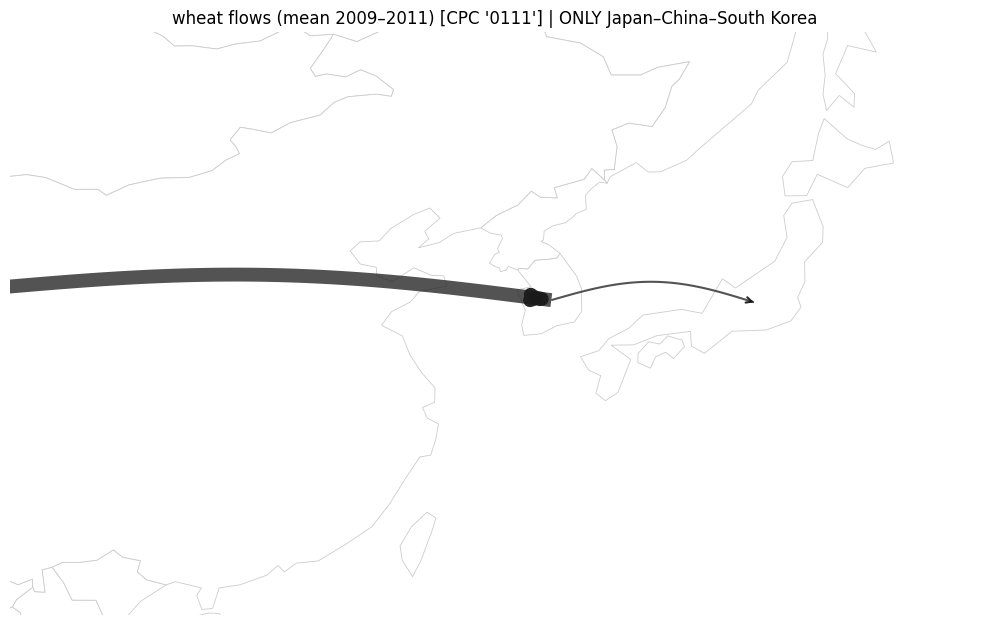

Saved: JPN_CHN_KOR_only_wheat.png
Saved edges csv.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def mat_to_edges_all(mat, min_value=0.0):
    df = mat.stack().reset_index()
    df.columns = ["exporter","importer","value"]
    df["value"] = pd.to_numeric(df["value"], errors="coerce").fillna(0.0)
    return df[df["value"] > float(min_value)].copy()

def normalize_country_name_for_filter(name: str) -> str:
    s = str(name).strip()
    if s in ["China, mainland", "China (mainland)", "China"]:
        return "China"
    if s in ["Korea, Rep.", "Republic of Korea", "South Korea", "Korea, South"]:
        return "South Korea"
    if s == "Japan":
        return "Japan"
    return s

def scale_width(v, wmin, wmax, use_log=True):
    v = np.asarray(v, dtype=float)
    v_use = np.log1p(v) if use_log else v
    vmin, vmax = float(v_use.min()), float(v_use.max())
    if vmax == vmin:
        return np.full(len(v_use), (wmin + wmax) / 2.0)
    return wmin + (v_use - vmin) * (wmax - wmin) / (vmax - vmin + 1e-12)

def add_arrowheads(ax, segs, widths, color_rgba, alpha=0.95):
    # 3国間なら本数が少ないので全部に矢印でOK
    for pts, w in zip(segs, widths):
        ax.annotate(
            "",
            xy=(pts[-1,0], pts[-1,1]),
            xytext=(pts[-3,0], pts[-3,1]),
            arrowprops=dict(
                arrowstyle="->",
                lw=float(w),
                color=(color_rgba[0], color_rgba[1], color_rgba[2], alpha),
                shrinkA=0, shrinkB=0,
            ),
            zorder=5
        )

def build_segments_safe(df, lookup, curvature=0.10, n=100):
    """
    Robust version (NO apply(pd.Series) assignment).
    df columns: exporter, importer, value
    """
    df2 = df.copy()

    # 1) lookup lon/lat separately (robust)
    lonlat1 = df2["exporter"].map(lambda x: lookup(str(x)) if lookup(str(x)) is not None else (np.nan, np.nan))
    lonlat2 = df2["importer"].map(lambda x: lookup(str(x)) if lookup(str(x)) is not None else (np.nan, np.nan))

    df2["lon1"] = lonlat1.map(lambda t: t[0])
    df2["lat1"] = lonlat1.map(lambda t: t[1])
    df2["lon2"] = lonlat2.map(lambda t: t[0])
    df2["lat2"] = lonlat2.map(lambda t: t[1])

    df2 = df2.dropna(subset=["lon1","lat1","lon2","lat2"]).copy()

    segs = [
        curved_line(r.lon1, r.lat1, r.lon2, r.lat2, curvature=curvature, n=n)
        for r in df2.itertuples(index=False)
    ]
    return df2, segs

def extract_and_plot_only_JPN_CHN_KOR(
    mat,
    crop_label="wheat",
    cpc_label="0111",
    min_value=0.0,
    ne_scale="110m",
    out_png="JPN_CHN_KOR_only.png",
    drop_self=True,
    use_log_width=True,
    width_range=(1.5, 10.0),
    curvature=0.10,
    add_arrows=True,
):
    edges_all = mat_to_edges_all(mat, min_value=min_value)

    edges_all["exporter_n"] = edges_all["exporter"].map(normalize_country_name_for_filter)
    edges_all["importer_n"] = edges_all["importer"].map(normalize_country_name_for_filter)

    focus = {"Japan", "China", "South Korea"}

    edges = edges_all[
        edges_all["exporter_n"].isin(focus) &
        edges_all["importer_n"].isin(focus)
    ].copy()

    if drop_self:
        edges = edges[edges["exporter_n"] != edges["importer_n"]].copy()

    print("Edges among JPN/CHN/KOR:", len(edges))
    display(edges.sort_values("value", ascending=False))

    # world + lookup
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(
        world,
        extra_alias={
            "China, mainland": "China",
            "Korea, Rep.": "South Korea",
            "Republic of Korea": "South Korea",
            "Japan": "Japan",
        }
    )

    # use normalized names for plotting labels
    edges_plot = edges[["exporter_n","importer_n","value"]].rename(
        columns={"exporter_n":"exporter", "importer_n":"importer"}
    ).copy()

    edges2, segs = build_segments_safe(edges_plot, lookup, curvature=curvature, n=100)
    if edges2.empty:
        raise RuntimeError("No edges remain after coordinate lookup. (country name mismatch?)")

    widths = scale_width(edges2["value"].values, width_range[0], width_range[1], use_log=use_log_width)

    fig, ax = plt.subplots(figsize=(10, 7))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    color = (0.1, 0.1, 0.1, 0.75)
    lc = LineCollection(segs, linewidths=widths, colors=[color]*len(segs), zorder=3)
    ax.add_collection(lc)

    if add_arrows:
        add_arrowheads(ax, segs, widths, color_rgba=color, alpha=0.95)

    # zoom East Asia
    ax.set_xlim(100, 150)
    ax.set_ylim(20, 50)
    ax.axis("off")
    ax.set_title(f"{crop_label} flows (mean 2009–2011) [CPC '{cpc_label}'] | ONLY Japan–China–South Korea")

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

    return edges2

# =========================
# RUN
# =========================
edges_jck_only = extract_and_plot_only_JPN_CHN_KOR(
    mat,
    crop_label="wheat",
    cpc_label="0111",
    min_value=0.0,
    out_png="JPN_CHN_KOR_only_wheat.png",
    drop_self=True,
    add_arrows=True
)

# save
edges_jck_only.to_csv("edges_JPN_CHN_KOR_only_wheat_cpc0111_2009_2011.csv", index=False)
print("Saved edges csv.")


# コメについても行列作ろう

In [36]:
import pandas as pd
import numpy as np

# =========================
# 0) Load
# =========================
df = pd.read_pickle("trade_full.pkl")

# =========================
# 1) Constants
# =========================
REPORTER = "Reporter Countries"
PARTNER  = "Partner Countries"
ITEMCPC  = "Item Code (CPC)"
ELEMENT  = "Element"

# =========================
# 2) Build yearly E/I edges
# =========================
def _prep_export_edges(df, year, item="'23161.02"):
    """
    Export quantity:
      reporter = exporter
      partner  = importer
    """
    ycol = f"Y{year}"
    d = df.loc[
        df[ITEMCPC].astype(str).str.contains(str(item), na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("export quantity"),
        [REPORTER, PARTNER, ycol]
    ].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    d = d.dropna(subset=[ycol])

    # remove zeros (keeps file smaller; if you want keep, comment out)
    d = d[d[ycol] != 0]

    ex = (d.groupby([REPORTER, PARTNER], as_index=False)[ycol].sum()
            .rename(columns={REPORTER: "exporter", PARTNER: "importer", ycol: "E"}))
    return ex

def _prep_import_edges_goodsflow(df, year, item="'23161.02"):
    """
    Import quantity in FAO:
      reporter = importer
      partner  = exporter
    Convert to goods-flow:
      exporter = partner
      importer = reporter
    """
    ycol = f"Y{year}"
    d = df.loc[
        df[ITEMCPC].astype(str).str.contains(str(item), na=False) &
        df[ELEMENT].astype(str).str.strip().str.lower().eq("import quantity"),
        [REPORTER, PARTNER, ycol]
    ].copy()

    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    d = d.dropna(subset=[ycol])
    d = d[d[ycol] != 0]

    im = (d.groupby([PARTNER, REPORTER], as_index=False)[ycol].sum()
            .rename(columns={PARTNER: "exporter", REPORTER: "importer", ycol: "I"}))
    return im

# =========================
# 3) Reconcile per year
# =========================
def reconcile_year(df, year, item="'23161.02"):
    """
    For each pair (exporter, importer) in the year:
      - if both E and I exist: value = (E+I)/2
      - if only one exists: value = that one
      - if none: absent
    Returns:
      exporter, importer, year, value, flag, E, I
    """
    ex = _prep_export_edges(df, year, item=item)
    im = _prep_import_edges_goodsflow(df, year, item=item)

    m = ex.merge(im, on=["exporter", "importer"], how="outer")

    both  = m["E"].notna() & m["I"].notna()
    onlyE = m["E"].notna() & m["I"].isna()
    onlyI = m["E"].isna()  & m["I"].notna()

    m["value"] = np.nan
    m.loc[both,  "value"] = 0.5 * (m.loc[both, "E"] + m.loc[both, "I"])
    m.loc[onlyE, "value"] = m.loc[onlyE, "E"]
    m.loc[onlyI, "value"] = m.loc[onlyI, "I"]

    m["flag"] = np.select(
        [both, onlyE, onlyI],
        ["mean(E,I)", "only_export_report", "only_import_report"],
        default="none"
    )

    out = m.loc[m["value"].notna(), ["exporter", "importer", "value", "flag", "E", "I"]].copy()
    out["year"] = year
    return out.reset_index(drop=True)

# =========================
# 4) 2009–2011 average (ignore missing years)
# =========================
def reconcile_and_average(df, years=(2009, 2010, 2011), item="'23161.02"):
    yearly = pd.concat([reconcile_year(df, y, item=item) for y in years], ignore_index=True)

    avg = (yearly.groupby(["exporter", "importer"], as_index=False)["value"]
                 .mean()
                 .rename(columns={"value": f"value_mean_{years[0]}_{years[-1]}"}))
    return avg, yearly

# =========================
# 5) Run + Save
# =========================
ITEM  = "'23161.02"
YEARS = (2009, 2010, 2011)

avg_3yr, yearly_detail = reconcile_and_average(df, years=YEARS, item=ITEM)

# quick sanity
print("yearly rows:", len(yearly_detail))
print("avg pairs:", len(avg_3yr))
display(avg_3yr.head(20))
display(yearly_detail.head(20))

# Save to CSV
avg_path = f"cpc23161.02_export_reconciled_mean_{YEARS[0]}_{YEARS[-1]}.csv"
yr_path  = f"cpc23161.02_export_reconciled_yearly_{YEARS[0]}_{YEARS[-1]}.csv"

avg_3yr.to_csv(avg_path, index=False)
yearly_detail.to_csv(yr_path, index=False)

print("Saved:", avg_path)
print("Saved:", yr_path)


yearly rows: 7377
avg pairs: 3413


exporter                          importer  \
0           Afghanistan                        Azerbaijan   
1           Afghanistan        Iran (Islamic Republic of)   
2           Afghanistan                          Pakistan   
3               Albania                            Serbia   
4               Algeria                             Benin   
5               Algeria                            France   
6               Algeria                             Niger   
7   Antigua and Barbuda                             Ghana   
8             Argentina                           Albania   
9             Argentina                           Algeria   
10            Argentina                            Angola   
11            Argentina                         Argentina   
12            Argentina                         Australia   
13            Argentina                           Belarus   
14            Argentina                           Belgium   
15            Argentina                             Benin   
16            Argentina  Bolivia (Plurinational State of)   
17            Argentina                            Brazil   
18            Argentina                            Canada   
19            Argentina                             Chile   

    value_mean_2009_2011  
0               3.000000  
1              68.000000  
2             916.000000  
3              34.000000  
4              24.000000  
5              20.000000  
6             410.000000  
7              24.000000  
8            1737.500000  
9             250.000000  
10           8406.333333  
11             57.500000  
12             22.000000  
13              1.500000  
14            300.000000  
15           6848.000000  
16           5600.500000  
17         156985.166667  
18             97.833333  
19          69131.333333

exporter                          importer     value  \
0           Afghanistan                        Azerbaijan       3.0   
1           Afghanistan                          Pakistan     916.0   
2               Albania                            Serbia      48.0   
3               Algeria                             Benin      24.0   
4               Algeria                            France      20.0   
5   Antigua and Barbuda                             Ghana      24.0   
6             Argentina                           Albania    2475.0   
7             Argentina                           Algeria     250.0   
8             Argentina                            Angola    2219.0   
9             Argentina                         Argentina      29.0   
10            Argentina                         Australia      22.0   
11            Argentina                           Belarus       2.0   
12            Argentina                           Belgium     500.0   
13            Argentina                             Benin    5496.0   
14            Argentina  Bolivia (Plurinational State of)   13181.5   
15            Argentina                            Brazil  133135.0   
16            Argentina                            Canada     123.0   
17            Argentina                             Chile   87180.5   
18            Argentina                        Costa Rica     125.0   
19            Argentina                              Cuba     298.0   

                  flag         E         I  year  
0   only_import_report       NaN       3.0  2009  
1   only_import_report       NaN     916.0  2009  
2   only_export_report      48.0       NaN  2009  
3   only_import_report       NaN      24.0  2009  
4            mean(E,I)      20.0      20.0  2009  
5   only_import_report       NaN      24.0  2009  
6            mean(E,I)    2250.0    2700.0  2009  
7   only_export_report     250.0       NaN  2009  
8   only_export_report    2219.0       NaN  2009  
9   only_import_report       NaN      29.0  2009  
10  only_export_report      22.0       NaN  2009  
11  only_import_report       NaN       2.0  2009  
12  only_export_report     500.0       NaN  2009  
13           mean(E,I)     696.0   10296.0  2009  
14           mean(E,I)   12778.0   13585.0  2009  
15           mean(E,I)  134344.0  131926.0  2009  
16           mean(E,I)     113.0     133.0  2009  
17           mean(E,I)   91700.0   82661.0  2009  
18  only_export_report     125.0       NaN  2009  
19  only_export_report     298.0       NaN  2009

Saved: cpc23161.02_export_reconciled_mean_2009_2011.csv
Saved: cpc23161.02_export_reconciled_yearly_2009_2011.csv


In [37]:

# --- あなたの pivot（ここはそのまま）
mat = avg_3yr.pivot_table(
    index="exporter",
    columns="importer",
    values="value_mean_2009_2011",
    fill_value=0.0
)

# =========================
# 保存（追加する部分）
# =========================

YEARS = (2009, 2010, 2011)
ITEM  = "'23161.02"

# 1) 行列CSV（Excelでも見れる）
mat_csv_path = f"cpc23161.02_matrix_mean_{YEARS[0]}_{YEARS[-1]}.csv"
mat.to_csv(mat_csv_path)

# 2) 行列pickle（次回すぐ読むため）
mat_pkl_path = f"cpc23161.02_matrix_mean_{YEARS[0]}_{YEARS[-1]}.pkl"
mat.to_pickle(mat_pkl_path)

# 3) （任意）parquet（小さくて高速・pyarrow必要）
try:
    mat_parquet_path = f"cpc23161.02_matrix_mean_{YEARS[0]}_{YEARS[-1]}.parquet"
    mat.to_parquet(mat_parquet_path)
    parquet_ok = True
except Exception as e:
    parquet_ok = False
    print("Parquet save skipped (pyarrow not installed?):", e)

print("Saved matrix CSV :", mat_csv_path)
print("Saved matrix PKL :", mat_pkl_path)
if parquet_ok:
    print("Saved matrix Parquet:", mat_parquet_path)

# 4) ちょい確認
print("matrix shape:", mat.shape)
print("nonzero links:", int((mat.values > 0).sum()))
display(mat.iloc[:10, :10])


Saved matrix CSV : cpc23161.02_matrix_mean_2009_2011.csv
Saved matrix PKL : cpc23161.02_matrix_mean_2009_2011.pkl
Saved matrix Parquet: cpc23161.02_matrix_mean_2009_2011.parquet
matrix shape: (155, 196)
nonzero links: 3413


importer             Afghanistan  Albania  Algeria       Angola  \
exporter                                                          
Afghanistan                  0.0      0.0      0.0     0.000000   
Albania                      0.0      0.0      0.0     0.000000   
Algeria                      0.0      0.0      0.0     0.000000   
Antigua and Barbuda          0.0      0.0      0.0     0.000000   
Argentina                    0.0   1737.5    250.0  8406.333333   
Australia                   32.0      0.0      1.0     0.000000   
Austria                      0.0      4.0      0.0     0.000000   
Azerbaijan                   0.0      0.0      0.0     0.000000   
Bahamas                      0.0      0.0      0.0     0.000000   
Bahrain                      0.0      0.0      0.0     0.000000   

importer             Antigua and Barbuda  Argentina  Armenia  Australia  \
exporter                                                                  
Afghanistan                          0.0        0.0      0.0   0.000000   
Albania                              0.0        0.0      0.0   0.000000   
Algeria                              0.0        0.0      0.0   0.000000   
Antigua and Barbuda                  0.0        0.0      0.0   0.000000   
Argentina                            0.0       57.5      0.0  22.000000   
Australia                            0.0        0.0      0.0  44.666667   
Austria                              0.0        0.0      0.0   0.000000   
Azerbaijan                           0.0        0.0      0.0   0.000000   
Bahamas                              0.0        0.0      0.0   0.000000   
Bahrain                              0.0        0.0      0.0   0.000000   

importer             Austria  Azerbaijan  
exporter                                  
Afghanistan              0.0         3.0  
Albania                  0.0         0.0  
Algeria                  0.0         0.0  
Antigua and Barbuda      0.0         0.0  
Argentina                0.0         0.0  
Australia                0.0         0.0  
Austria                  0.0         0.0  
Azerbaijan               0.0         0.0  
Bahamas                  0.0         0.0  
Bahrain                  0.0         0.0

# Rice_milled　読み込み時はこのコード

In [48]:
mat = pd.read_pickle("cpc23161.02_matrix_mean_2009_2011.pkl")
# または
#mat = pd.read_csv("cpc23161.02_matrix_mean_2009_2011.csv", index_col=0)

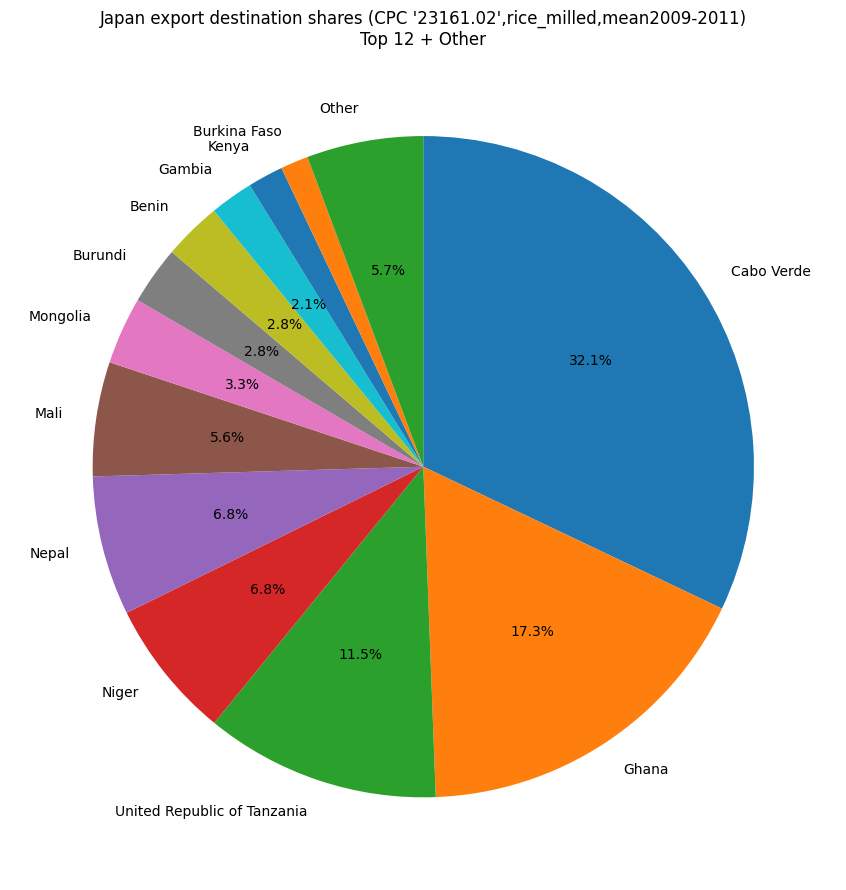

share  share_pct
Cabo Verde                   0.320580  32.058022
Ghana                        0.173416  17.341596
United Republic of Tanzania  0.114920  11.492007
Niger                        0.068227   6.822707
Nepal                        0.068141   6.814107
Other                        0.056989   5.698898
Mali                         0.055853   5.585250
Mongolia                     0.032874   3.287406
Burundi                      0.028452   2.845240
Benin                        0.028412   2.841193
Gambia                       0.021198   2.119764
Kenya                        0.017363   1.736284
Burkina Faso                 0.013575   1.357526

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
EXPORTER = "Japan"     # ← FAO表記に合わせて変える（候補検索も下に用意）
TOPK = 12                  # 上位何カ国まで円グラフに出すか（残りはOtherへ）
MIN_SHARE = 0.01           # 1%未満はOtherへ（TOPKと併用）

# =========================
# Helper: country name search
# =========================
def search_exporter_name(mat, keyword="japan"):
    idx = pd.Index(mat.index.astype(str))
    return idx[idx.str.contains(keyword, case=False, na=False)].tolist()

# もし名前がヒットしない時は：
# print(search_exporter_name(mat, "japan"))

# =========================
# 1) Extract exporter row
# =========================
if EXPORTER not in mat.index:
    raise ValueError(f"Exporter '{EXPORTER}' not found. Try: search_exporter_name(mat, 'argen')")

row = mat.loc[EXPORTER].copy()

# remove self-loop if exists
if EXPORTER in row.index:
    row.loc[EXPORTER] = 0.0

# keep positive only
row = row[row > 0].sort_values(ascending=False)

total = row.sum()
if total <= 0:
    raise ValueError(f"No positive exports found for {EXPORTER}.")

share = (row / total).sort_values(ascending=False)

# =========================
# 2) Aggregate to TopK + Other
# =========================
share_filtered = share.copy()

# apply MIN_SHARE first
small = share_filtered[share_filtered < MIN_SHARE]
share_filtered = share_filtered[share_filtered >= MIN_SHARE]

# ensure at most TOPK items
if len(share_filtered) > TOPK:
    top = share_filtered.iloc[:TOPK]
    rest = share_filtered.iloc[TOPK:]
    other_share = rest.sum() + small.sum()
    share_plot = pd.concat([top, pd.Series({"Other": other_share})])
else:
    other_share = small.sum()
    if other_share > 0:
        share_plot = pd.concat([share_filtered, pd.Series({"Other": other_share})])
    else:
        share_plot = share_filtered

# normalize (just in case numerical issues)
share_plot = share_plot / share_plot.sum()

# =========================
# 3) Plot pie chart
# =========================
labels = share_plot.index.tolist()
sizes  = share_plot.values

plt.figure(figsize=(9, 9))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%" if p >= 2 else "",  # small slices no label
    startangle=90,
    counterclock=False
)
plt.title(f"{EXPORTER} export destination shares (CPC '23161.02',rice_milled,mean2009-2011)\nTop {TOPK} + Other")
plt.tight_layout()
plt.show()

# =========================
# 4) Print table (for sanity)
# =========================
out_table = (share_plot.rename("share")
             .to_frame()
             .assign(share_pct=lambda d: 100*d["share"])
             .sort_values("share", ascending=False))

display(out_table)


Global edges plotted: 345
Japan EXPORT edges plotted: 61
Japan IMPORT edges plotted: 9


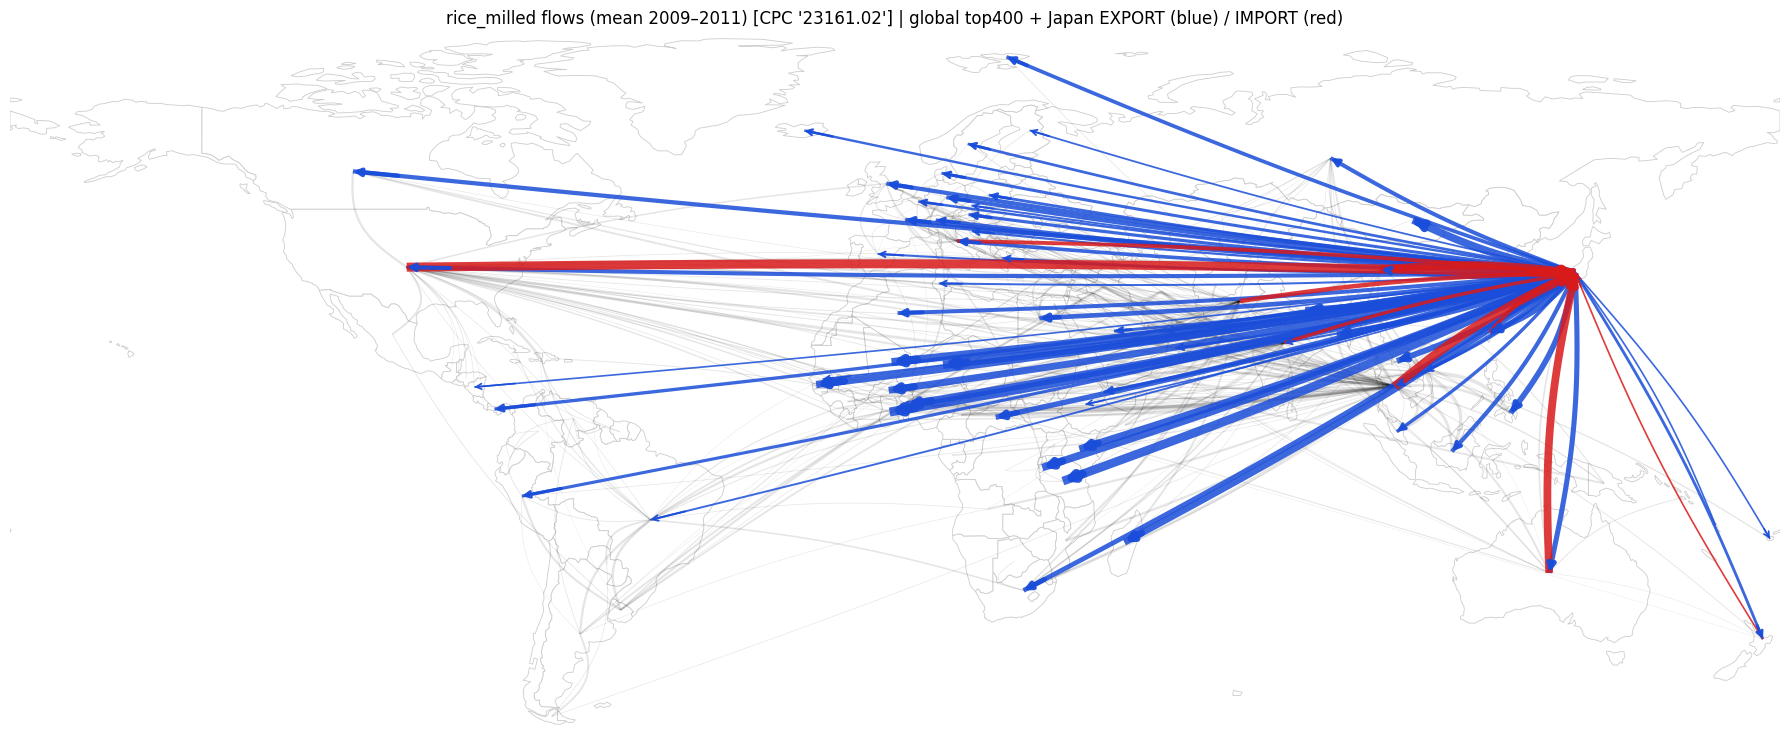

Saved: world_focus_Japan_rice_milled_23161.02.png


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# =========================================
# Required pre-defined functions in your notebook:
#   - load_naturalearth_admin0_countries(scale="110m" or "50m")
#   - build_coord_lookup_from_world(world_gdf, extra_alias=None)
#   - curved_line(lon1, lat1, lon2, lat2, curvature=..., n=...)
# =========================================


def mat_to_edges_all(mat, min_value=0.0):
    df = mat.stack().reset_index()
    df.columns = ["exporter", "importer", "value"]
    df = df[df["value"] > min_value].copy()
    return df


def build_segments(df, lookup, curvature=0.18, n=50):
    """
    df columns: exporter, importer, value
    returns (df2 with lon/lat) and list of curved polylines (Nx2 arrays)
    """
    df2 = df.copy()

    def get_ll(name):
        ll = lookup(str(name))
        return (np.nan, np.nan) if ll is None else ll

    df2[["lon1", "lat1"]] = df2["exporter"].apply(lambda x: pd.Series(get_ll(x)))
    df2[["lon2", "lat2"]] = df2["importer"].apply(lambda x: pd.Series(get_ll(x)))
    df2 = df2.dropna(subset=["lon1", "lat1", "lon2", "lat2"]).copy()

    segs = [
        curved_line(r.lon1, r.lat1, r.lon2, r.lat2, curvature=curvature, n=n)
        for r in df2.itertuples(index=False)
    ]
    return df2, segs


def scale_width(v, wmin, wmax, use_log=True):
    v = np.asarray(v, dtype=float)
    v_use = np.log1p(v) if use_log else v
    vmin, vmax = float(v_use.min()), float(v_use.max())
    if vmax == vmin:
        return np.full(len(v_use), (wmin + wmax) / 2.0)
    return wmin + (v_use - vmin) * (wmax - wmin) / (vmax - vmin + 1e-12)


def add_arrowheads(ax, segs, widths, color_rgba, topK=80, alpha=0.9):
    """
    Add arrowheads for topK thickest edges (based on widths or original value ranking).
    We place arrow using last segment of the polyline.
    """
    if topK is None or topK <= 0:
        return

    # choose topK by width (proxy for value)
    idx = np.argsort(-np.asarray(widths))[:min(int(topK), len(segs))]

    for i in idx:
        pts = segs[i]
        w = float(widths[i])
        # use last few points to orient arrow
        ax.annotate(
            "",
            xy=(pts[-1, 0], pts[-1, 1]),
            xytext=(pts[-3, 0], pts[-3, 1]),
            arrowprops=dict(
                arrowstyle="->",
                lw=w,
                color=(color_rgba[0], color_rgba[1], color_rgba[2], alpha),
                shrinkA=0,
                shrinkB=0,
            ),
            zorder=5
        )


def plot_world_with_focus_direction(
    mat,
    focus="Japan",
    crop_label="rice_milled",
    cpc_label="23161.02",
    topK_global=400,       # 背景：世界上位K本
    topK_focus=120,        # Japan輸出上位K + Japan輸入上位K（それぞれ）
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus_Japan_rice_milled_23161.02.png",

    # style
    curvature_global=0.22,
    curvature_focus=0.12,
    use_log_width=True,

    width_global=(0.25, 2.6),
    width_focus=(1.2, 6.5),

    # colors (RGBA)
    global_color=(0, 0, 0, 0.10),      # light gray
    export_color=(0.10, 0.30, 0.85, 0.85),  # blue-ish
    import_color=(0.85, 0.10, 0.10, 0.85),  # red-ish

    # arrowheads only for focus edges (avoid clutter)
    arrow_topK_each=60,     # export/importそれぞれ上位何本に矢印を付けるか
    arrow_alpha=0.95
):
    # world + lookup
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(
        world,
        extra_alias={
            "China, mainland": "China",
            "Viet Nam": "Vietnam",
            "Russian Federation": "Russia",
            "United States of America": "United States of America",
            "Japan": "Japan",
        }
    )

    # --- global edges (background) ---
    edges_all = mat_to_edges_all(mat, min_value=min_value)
    edges_global = edges_all.sort_values("value", ascending=False).head(topK_global)

    # --- focus export edges: focus -> others ---
    edges_export = edges_all[edges_all["exporter"] == focus].sort_values("value", ascending=False).head(topK_focus)

    # --- focus import edges: others -> focus ---
    edges_import = edges_all[edges_all["importer"] == focus].sort_values("value", ascending=False).head(topK_focus)

    # segments
    edges_global2, segs_global = build_segments(edges_global, lookup, curvature=curvature_global, n=50)
    edges_export2, segs_export = build_segments(edges_export, lookup, curvature=curvature_focus, n=55)
    edges_import2, segs_import = build_segments(edges_import, lookup, curvature=curvature_focus, n=55)

    print(f"Global edges plotted: {len(edges_global2)}")
    print(f"{focus} EXPORT edges plotted: {len(edges_export2)}")
    print(f"{focus} IMPORT edges plotted: {len(edges_import2)}")

    # widths
    w_g = scale_width(edges_global2["value"].values, width_global[0], width_global[1], use_log=use_log_width) if len(edges_global2) else []
    w_e = scale_width(edges_export2["value"].values, width_focus[0], width_focus[1], use_log=use_log_width) if len(edges_export2) else []
    w_i = scale_width(edges_import2["value"].values, width_focus[0], width_focus[1], use_log=use_log_width) if len(edges_import2) else []

    # plot
    fig, ax = plt.subplots(figsize=(18, 9))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    # global background
    if len(segs_global):
        lc_g = LineCollection(segs_global, linewidths=w_g, colors=[global_color] * len(segs_global), zorder=2)
        ax.add_collection(lc_g)

    # focus export (blue)
    if len(segs_export):
        lc_e = LineCollection(segs_export, linewidths=w_e, colors=[export_color] * len(segs_export), zorder=3)
        ax.add_collection(lc_e)

    # focus import (red)
    if len(segs_import):
        lc_i = LineCollection(segs_import, linewidths=w_i, colors=[import_color] * len(segs_import), zorder=4)
        ax.add_collection(lc_i)

    # arrowheads only for focus edges (topK each)
    if len(segs_export):
        add_arrowheads(ax, segs_export, w_e, export_color, topK=arrow_topK_each, alpha=arrow_alpha)
    if len(segs_import):
        add_arrowheads(ax, segs_import, w_i, import_color, topK=arrow_topK_each, alpha=arrow_alpha)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 85)
    ax.axis("off")

    ax.set_title(
        f"{crop_label} flows (mean 2009–2011) [CPC '{cpc_label}'] | "
        f"global top{topK_global} + {focus} EXPORT (blue) / IMPORT (red)"
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

    return edges_global2, edges_export2, edges_import2


# =========================
# RUN: Japan version
# =========================
edges_global2, edges_jp_exp, edges_jp_imp = plot_world_with_focus_direction(
    mat,
    focus="Japan",
    crop_label="rice_milled",     # 表示上は rice_milled
    cpc_label="23161.02",
    topK_global=400,
    topK_focus=120,
    min_value=0.0,
    ne_scale="110m",
    out_png="world_focus_Japan_rice_milled_23161.02.png",
    arrow_topK_each=60      # 矢印は多すぎると汚いので上位だけ
)


Edges among JPN/CHN/KOR: 5


exporter           importer         value   exporter_n  \
6024     China, mainland  Republic of Korea  55198.000000        China   
5970     China, mainland              Japan  46704.000000        China   
22577  Republic of Korea    China, mainland    590.666667  South Korea   
13757              Japan    China, mainland     61.250000        Japan   
22630  Republic of Korea              Japan      6.500000  South Korea   

        importer_n  
6024   South Korea  
5970         Japan  
22577        China  
13757        China  
22630        Japan

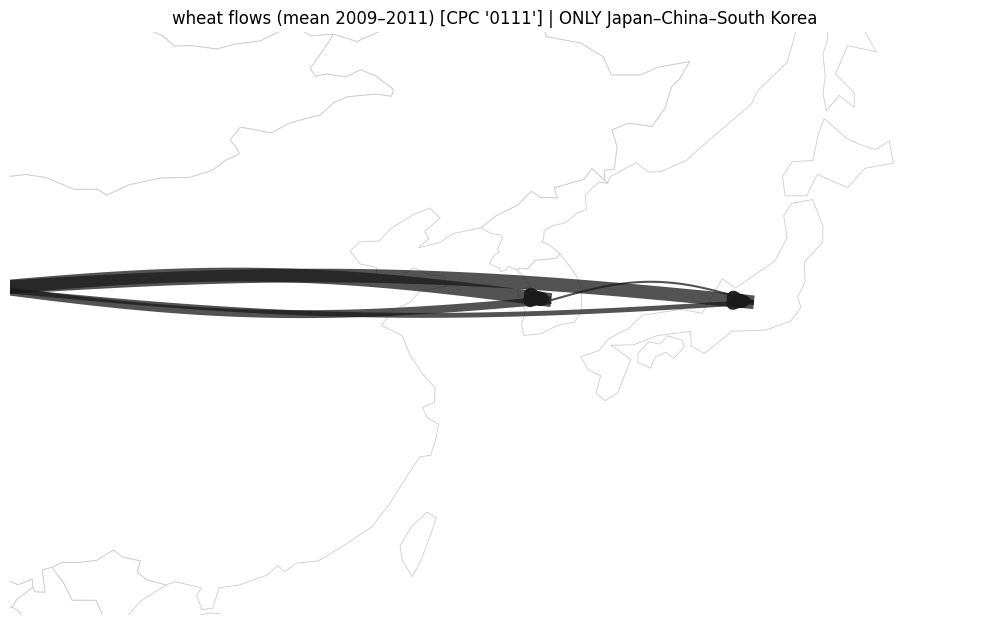

Saved: JPN_CHN_KOR_only_rice_milled.png
Saved edges csv.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def mat_to_edges_all(mat, min_value=0.0):
    df = mat.stack().reset_index()
    df.columns = ["exporter","importer","value"]
    df["value"] = pd.to_numeric(df["value"], errors="coerce").fillna(0.0)
    return df[df["value"] > float(min_value)].copy()

def normalize_country_name_for_filter(name: str) -> str:
    s = str(name).strip()
    if s in ["China, mainland", "China (mainland)", "China"]:
        return "China"
    if s in ["Korea, Rep.", "Republic of Korea", "South Korea", "Korea, South"]:
        return "South Korea"
    if s == "Japan":
        return "Japan"
    return s

def scale_width(v, wmin, wmax, use_log=True):
    v = np.asarray(v, dtype=float)
    v_use = np.log1p(v) if use_log else v
    vmin, vmax = float(v_use.min()), float(v_use.max())
    if vmax == vmin:
        return np.full(len(v_use), (wmin + wmax) / 2.0)
    return wmin + (v_use - vmin) * (wmax - wmin) / (vmax - vmin + 1e-12)

def add_arrowheads(ax, segs, widths, color_rgba, alpha=0.95):
    # 3国間なら本数が少ないので全部に矢印でOK
    for pts, w in zip(segs, widths):
        ax.annotate(
            "",
            xy=(pts[-1,0], pts[-1,1]),
            xytext=(pts[-3,0], pts[-3,1]),
            arrowprops=dict(
                arrowstyle="->",
                lw=float(w),
                color=(color_rgba[0], color_rgba[1], color_rgba[2], alpha),
                shrinkA=0, shrinkB=0,
            ),
            zorder=5
        )

def build_segments_safe(df, lookup, curvature=0.10, n=100):
    """
    Robust version (NO apply(pd.Series) assignment).
    df columns: exporter, importer, value
    """
    df2 = df.copy()

    # 1) lookup lon/lat separately (robust)
    lonlat1 = df2["exporter"].map(lambda x: lookup(str(x)) if lookup(str(x)) is not None else (np.nan, np.nan))
    lonlat2 = df2["importer"].map(lambda x: lookup(str(x)) if lookup(str(x)) is not None else (np.nan, np.nan))

    df2["lon1"] = lonlat1.map(lambda t: t[0])
    df2["lat1"] = lonlat1.map(lambda t: t[1])
    df2["lon2"] = lonlat2.map(lambda t: t[0])
    df2["lat2"] = lonlat2.map(lambda t: t[1])

    df2 = df2.dropna(subset=["lon1","lat1","lon2","lat2"]).copy()

    segs = [
        curved_line(r.lon1, r.lat1, r.lon2, r.lat2, curvature=curvature, n=n)
        for r in df2.itertuples(index=False)
    ]
    return df2, segs

def extract_and_plot_only_JPN_CHN_KOR(
    mat,
    crop_label="rice_milled",
    cpc_label="23161.02",
    min_value=0.0,
    ne_scale="110m",
    out_png="rice_JPN_CHN_KOR_only.png",
    drop_self=True,
    use_log_width=True,
    width_range=(1.5, 10.0),
    curvature=0.10,
    add_arrows=True,
):
    edges_all = mat_to_edges_all(mat, min_value=min_value)

    edges_all["exporter_n"] = edges_all["exporter"].map(normalize_country_name_for_filter)
    edges_all["importer_n"] = edges_all["importer"].map(normalize_country_name_for_filter)

    focus = {"Japan", "China", "South Korea"}

    edges = edges_all[
        edges_all["exporter_n"].isin(focus) &
        edges_all["importer_n"].isin(focus)
    ].copy()

    if drop_self:
        edges = edges[edges["exporter_n"] != edges["importer_n"]].copy()

    print("Edges among JPN/CHN/KOR:", len(edges))
    display(edges.sort_values("value", ascending=False))

    # world + lookup
    world = load_naturalearth_admin0_countries(scale=ne_scale)
    lookup = build_coord_lookup_from_world(
        world,
        extra_alias={
            "China, mainland": "China",
            "Korea, Rep.": "South Korea",
            "Republic of Korea": "South Korea",
            "Japan": "Japan",
        }
    )

    # use normalized names for plotting labels
    edges_plot = edges[["exporter_n","importer_n","value"]].rename(
        columns={"exporter_n":"exporter", "importer_n":"importer"}
    ).copy()

    edges2, segs = build_segments_safe(edges_plot, lookup, curvature=curvature, n=100)
    if edges2.empty:
        raise RuntimeError("No edges remain after coordinate lookup. (country name mismatch?)")

    widths = scale_width(edges2["value"].values, width_range[0], width_range[1], use_log=use_log_width)

    fig, ax = plt.subplots(figsize=(10, 7))
    world.plot(ax=ax, color="white", edgecolor="#cccccc", linewidth=0.6, zorder=1)

    color = (0.1, 0.1, 0.1, 0.75)
    lc = LineCollection(segs, linewidths=widths, colors=[color]*len(segs), zorder=3)
    ax.add_collection(lc)

    if add_arrows:
        add_arrowheads(ax, segs, widths, color_rgba=color, alpha=0.95)

    # zoom East Asia
    ax.set_xlim(100, 150)
    ax.set_ylim(20, 50)
    ax.axis("off")
    ax.set_title(f"{crop_label} flows (mean 2009–2011) [CPC '{cpc_label}'] | ONLY Japan–China–South Korea")

    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print("Saved:", out_png)

    return edges2

# =========================
# RUN
# =========================
edges_jck_only = extract_and_plot_only_JPN_CHN_KOR(
    mat,
    crop_label="wheat",
    cpc_label="0111",
    min_value=0.0,
    out_png="JPN_CHN_KOR_only_rice_milled.png",
    drop_self=True,
    add_arrows=True
)

# save
edges_jck_only.to_csv("edges_JPN_CHN_KOR_only_rice_milled_cpc23161.02_2009_2011.csv", index=False)
print("Saved edges csv.")
